## MBA Admission dataset, Class 2025

A synthetic data generated from the Wharton Class of 2025's statistics, This notebook creates a SageMaker Pipeline to build an end-to-end Machine Learning system to solve the problem of classifying admission status for Wharton 2025.

https://www.kaggle.com/datasets/taweilo/mba-admission-dataset/data

## Session 1 - Introduction and Initial Setup

The **Aim** of the Notebook is to demonstrate how machine learning works on the AWS Sagemaker, from training to deployment of model
The machine learning system we'll build during this program consists of four main pipelines: A training pipeline, an inference pipeline, a deployment pipeline.




Setting the LOCAL_MODE variable to True will run every supported pipeline component locally. Setting the variable to False will run the pipeline in SageMaker.

In [1]:
import os
import json
import logging
import sys
import boto3
from io import StringIO 
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# By default, The SageMaker SDK logs events related to the default
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

In [2]:
# when set to true, i can run the jon on my machine rather than in the cloud
LOCAL_MODE = False


In [3]:
import boto3
from botocore.exceptions import ClientError

def create_s3_bucket(bucket_name, region=None):
    """
    Create an S3 bucket in a specified region.
    
    If the bucket already exists or is owned by you, skip creation and notify the user.
    
    :param bucket_name: Name of the bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket was created or already exists, else False
    """
    try:
        # Create the S3 client
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            s3_client.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region},
            )
        print(f"Bucket '{bucket_name}' created successfully in region '{region}'")
        return True
    except ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == 'BucketAlreadyExists':
            print(f"Bucket '{bucket_name}' already exists globally. Please choose a different name.")
            return False
        elif error_code == 'BucketAlreadyOwnedByYou':
            print(f"Bucket '{bucket_name}' already exists and is owned by you.")
            return True
        else:
            print(f"Error creating bucket: {e}")
            return False

# Example usage with corrected bucket name
bucket_name = "admission-list"  
# region = "us-west-2"  # Optional: specify a region, or leave as None

# Create the S3 bucket or notify if it already exists
create_s3_bucket(bucket_name)


Bucket 'admission-list' created successfully in region 'None'


True

In [4]:
# Create environment variables using os.environ
os.environ["role"] = "arn:aws:iam::025066244860:role/service-role/AmazonSageMaker-ExecutionRole-20240806T222736"
os.environ["bucket"] = "admission-list"
os.environ["COMET_API_KEY"] = "0p5jWqLBp36NhU9zYp2CfcPXf"
os.environ["COMET_PROJECT_NAME"] = "masters-list"

In [5]:
# Retrieve the environment variables using os.getenv
role = os.environ["role"]
bucket = os.environ["bucket"]
COMET_API_KEY = os.environ["COMET_API_KEY"]
COMET_PROJECT_NAME = os.environ["COMET_PROJECT_NAME"] 

# Print out the variables to verify they were set correctly (for demonstration purposes only)

If you are running the pipeline in Local Mode on an ARM64 machine (for example, on Apple Silicon), you will need to use a custom Docker image to train and evaluate the model. Let's create a variable indicating if we are running on an ARM64 machine., I already created the Docker image.

In [6]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command. 
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"
IS_ARM64_ARCHITECTURE


True

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode. We'll use this dictionary to configure the pipeline components.

In [7]:
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# TensorFlow container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

In [8]:


sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

In [9]:

CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "MBA.csv"

In [10]:


# Initialize a session using Amazon S3
s3_client = boto3.client('s3')

# Define your CORS configuration
cors_configuration = {
    'CORSRules':[
    {
        "AllowedHeaders": [
            "*"
        ],
        "AllowedMethods": [
            "POST",
            "PUT",
            "GET",
            "HEAD",
            "DELETE"
        ],
        "AllowedOrigins": [
            "https://*.sagemaker.aws"
        ],
        "ExposeHeaders": [
            "ETag",
            "x-amz-delete-marker",
            "x-amz-id-2",
            "x-amz-request-id",
            "x-amz-server-side-encryption",
            "x-amz-version-id"
        ]
    }
    ]
}

# Apply the CORS configuration to the S3 bucket
bucket_name = bucket
s3_client.put_bucket_cors(Bucket=bucket, CORSConfiguration=cors_configuration)

print(f"CORS configuration applied to bucket: {bucket_name}")


CORS configuration applied to bucket: admission-list


## Session 2 - Exploratory Data Analysis

The goal of this session is to understand the data and the problem we are trying to solve.

In [11]:
#  Let's load the admissions  dataset:

import numpy as np
import pandas as pd

admission_list = pd.read_csv(DATA_FILEPATH)
admission_list.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


We can see the dataset contains the following columns:

1. `application_id`: Unique identifier for each application.
2. `gender`: Applicant's gender (Male, Female)
3. `international`: International student (TRUE/FALSE)
4. `gpa`: Grade Point Average of the applicant (on 4.0 scale)
5. `major`: Undergraduate major (Business, STEM, Humanities)
6. `race`: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
7. `gmat`: MAT score of the applicant (800 points)
8. `work_exp`: Number of years of work experience (Year)
9. `work_industry`: Industry of the applicant's previous work experience (e.g., Consulting, Finance, Technology, etc.)
10. `admission`: Admission status (Admit, Waitlist, Null: Deny)

In [12]:
admission_list.describe(include="all")

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
count,6194.000000,6194,6194,6194.000000,6194,4352,6194.000000,6194.000000,6194,1000
unique,NaN,2,2,NaN,3,5,NaN,NaN,14,2
top,NaN,Male,False,NaN,Humanities,White,NaN,NaN,Consulting,Admit
freq,NaN,3943,4352,NaN,2481,1456,NaN,NaN,1619,900
mean,3097.500000,NaN,NaN,3.250714,NaN,NaN,651.092993,5.016952,NaN,NaN
std,1788.198115,NaN,NaN,0.151541,NaN,NaN,49.294883,1.032432,NaN,NaN
min,1.000000,NaN,NaN,2.650000,NaN,NaN,570.000000,1.000000,NaN,NaN
25%,1549.250000,NaN,NaN,3.150000,NaN,NaN,610.000000,4.000000,NaN,NaN
50%,3097.500000,NaN,NaN,3.250000,NaN,NaN,650.000000,5.000000,NaN,NaN
75%,4645.750000,NaN,NaN,3.350000,NaN,NaN,680.000000,6.000000,NaN,NaN


In [13]:
# list the column types
admission_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


In [14]:
# distribution of values for categorical data

gender_distribution = admission_list["gender"].value_counts()
major_distribution = admission_list["major"].value_counts()
race_distribution = admission_list["race"].value_counts()
work_industry_distribution = admission_list["work_industry"].value_counts()
admission_distribution = admission_list["admission"].value_counts()

print(gender_distribution, end="\n\n")
print(major_distribution, end="\n\n")
print(race_distribution, end ="\n\n" )
print(work_industry_distribution, end ="\n\n" )
print(admission_distribution)


gender
Male      3943
Female    2251
Name: count, dtype: int64

major
Humanities    2481
STEM          1875
Business      1838
Name: count, dtype: int64

race
White       1456
Asian       1147
Black        916
Hispanic     596
Other        237
Name: count, dtype: int64

work_industry
Consulting               1619
PE/VC                     907
Technology                716
Nonprofit/Gov             651
Investment Banking        580
Financial Services        451
Other                     421
Health Care               334
Investment Management     166
CPG                       114
Real Estate               111
Media/Entertainment        59
Retail                     33
Energy                     32
Name: count, dtype: int64

admission
Admit       900
Waitlist    100
Name: count, dtype: int64


In [15]:
## Let's display again the number of missing values:

admission_list.isna().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

In [16]:
## remember the data card where non value of race  are regarded as  international or others
## remember the data card where non value of admission  are regarded as  deny

admission_list['race'] = admission_list['race'].fillna('international')
admission_list['admission'] = admission_list['admission'].fillna('Deny')

print(admission_list["race"].value_counts(), end = "\n\n") 
print(admission_list["admission"].value_counts()) 

race
international    1842
White            1456
Asian            1147
Black             916
Hispanic          596
Other             237
Name: count, dtype: int64

admission
Deny        5194
Admit        900
Waitlist     100
Name: count, dtype: int64


In [17]:
## Let's display again the number of missing values:

admission_list.isna().sum()

application_id    0
gender            0
international     0
gpa               0
major             0
race              0
gmat              0
work_exp          0
work_industry     0
admission         0
dtype: int64

In [18]:
admission_list.head(10)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,3,Female,True,3.30,Business,international,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny
5,6,Male,False,3.18,Business,White,610.0,6.0,Consulting,Deny
6,7,Female,False,2.93,STEM,Other,590.0,3.0,Technology,Admit
7,8,Male,True,3.02,Business,international,630.0,6.0,Financial Services,Deny
8,9,Male,False,3.24,Business,White,590.0,2.0,Nonprofit/Gov,Deny
9,10,Male,False,3.27,Humanities,Asian,690.0,3.0,Consulting,Deny


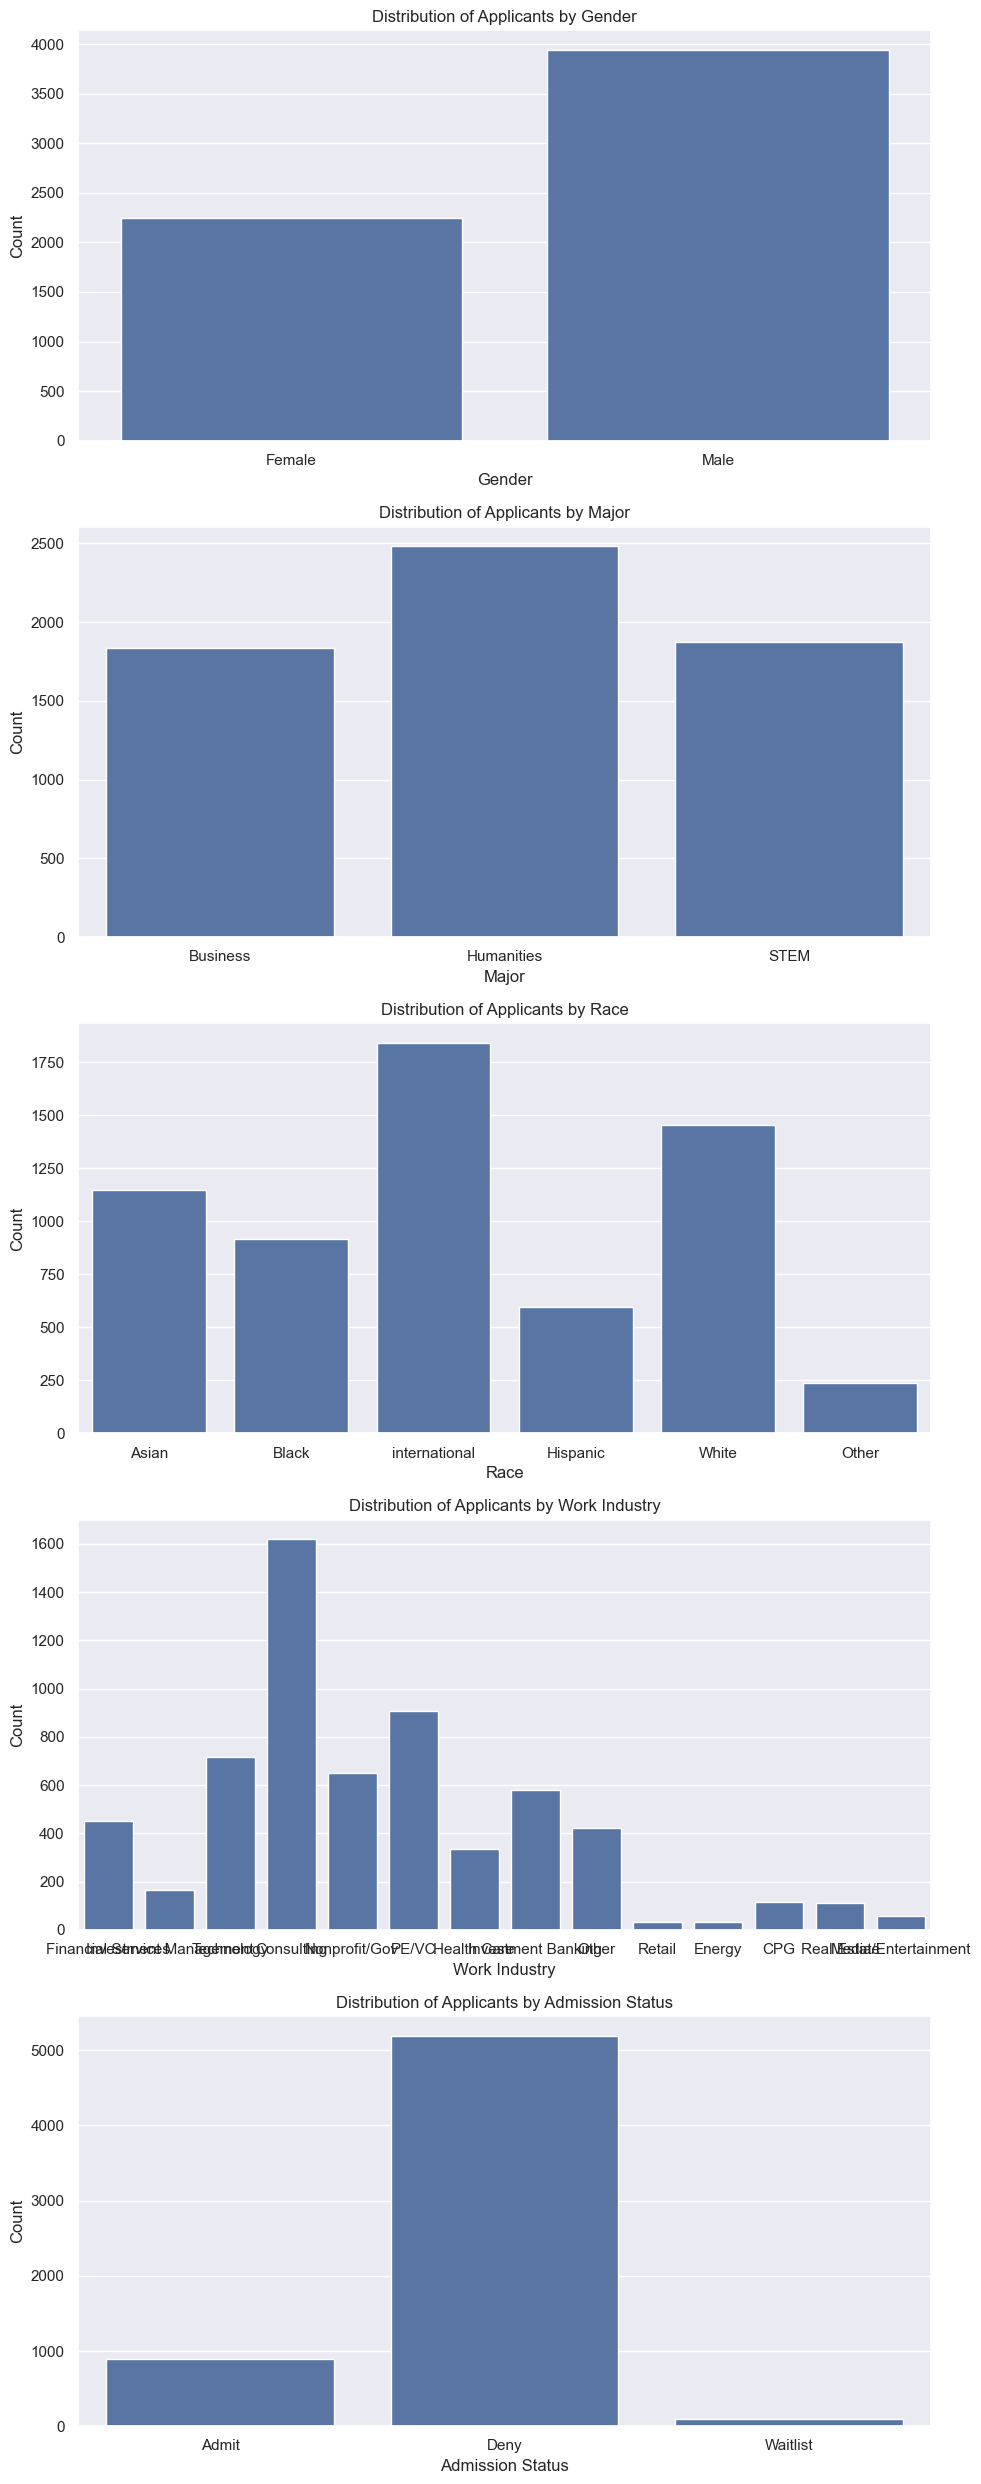

In [19]:
# Set the style of the plots
sns.set(style="darkgrid")

# Create a figure and an array of subplots with 5 rows and 1 column
fig, axs = plt.subplots(5, 1, figsize=(10, 25))  

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.4)

# Plot 1: Count plot for 'gender'
sns.countplot(data=admission_list, x='gender', ax=axs[0])
axs[0].set_title("Distribution of Applicants by Gender")
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Count")

# Plot 2: Count plot for 'major'
sns.countplot(data=admission_list, x='major', ax=axs[1],)
axs[1].set_title("Distribution of Applicants by Major")
axs[1].set_xlabel("Major")
axs[1].set_ylabel("Count")

# Plot 3: Count plot for 'race'
sns.countplot(data=admission_list, x='race', ax=axs[2])
axs[2].set_title("Distribution of Applicants by Race")
axs[2].set_xlabel("Race")
axs[2].set_ylabel("Count")

# Plot 4: Count plot for 'work_industry'
sns.countplot(data=admission_list, x='work_industry', ax=axs[3])
axs[3].set_title("Distribution of Applicants by Work Industry")
axs[3].set_xlabel("Work Industry")
axs[3].set_ylabel("Count")

# Plot 5: Count plot for 'admission'
sns.countplot(data=admission_list, x='admission', ax=axs[4])
axs[4].set_title("Distribution of Applicants by Admission Status")
axs[4].set_xlabel("Admission Status")
axs[4].set_ylabel("Count")

# Display the final plot with all subplots
plt.tight_layout()
plt.show()


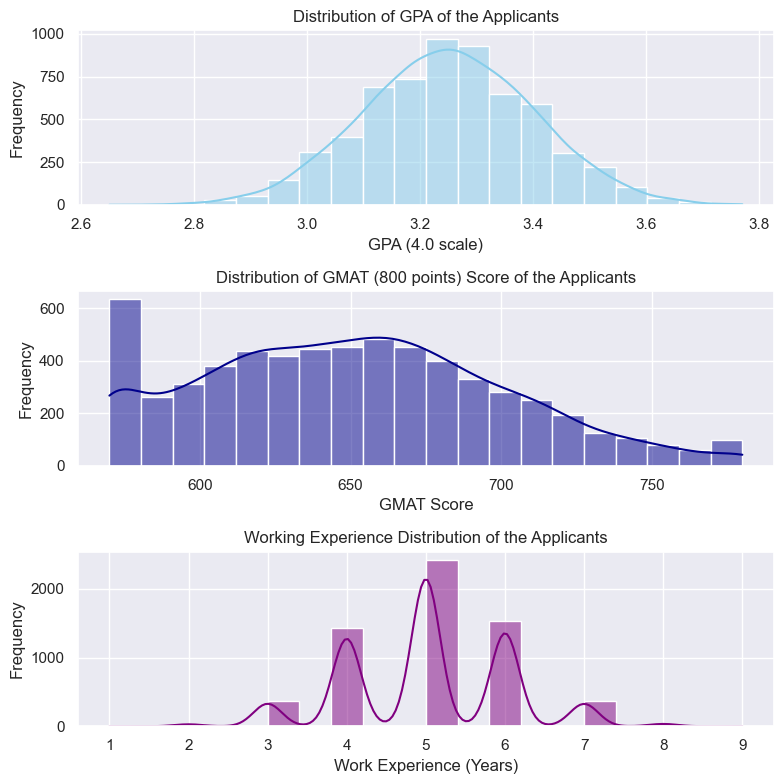

In [20]:

# Create a figure and an array of subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(8, 8))  # 3 rows, 1 column, and set figure size

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.4)

# Plot 1: Distribution of 'gpa'
sns.histplot(data=admission_list, x='gpa', bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title("Distribution of GPA of the Applicants")
axs[0].set_xlabel("GPA (4.0 scale)")
axs[0].set_ylabel("Frequency")

# Plot 2: Distribution of 'gmat'
sns.histplot(data=admission_list, x='gmat', bins=20, kde=True, color='darkblue', ax=axs[1])
axs[1].set_title("Distribution of GMAT (800 points) Score of the Applicants")
axs[1].set_xlabel("GMAT Score")
axs[1].set_ylabel("Frequency")

# Plot 3: Distribution of 'work_exp'
sns.histplot(data=admission_list, x='work_exp', bins=20, kde=True, color='purple', ax=axs[2])
axs[2].set_title("Working Experience Distribution of the Applicants")
axs[2].set_xlabel("Work Experience (Years)")
axs[2].set_ylabel("Frequency")

# Display the final plot with all subplots
plt.tight_layout()
plt.show()


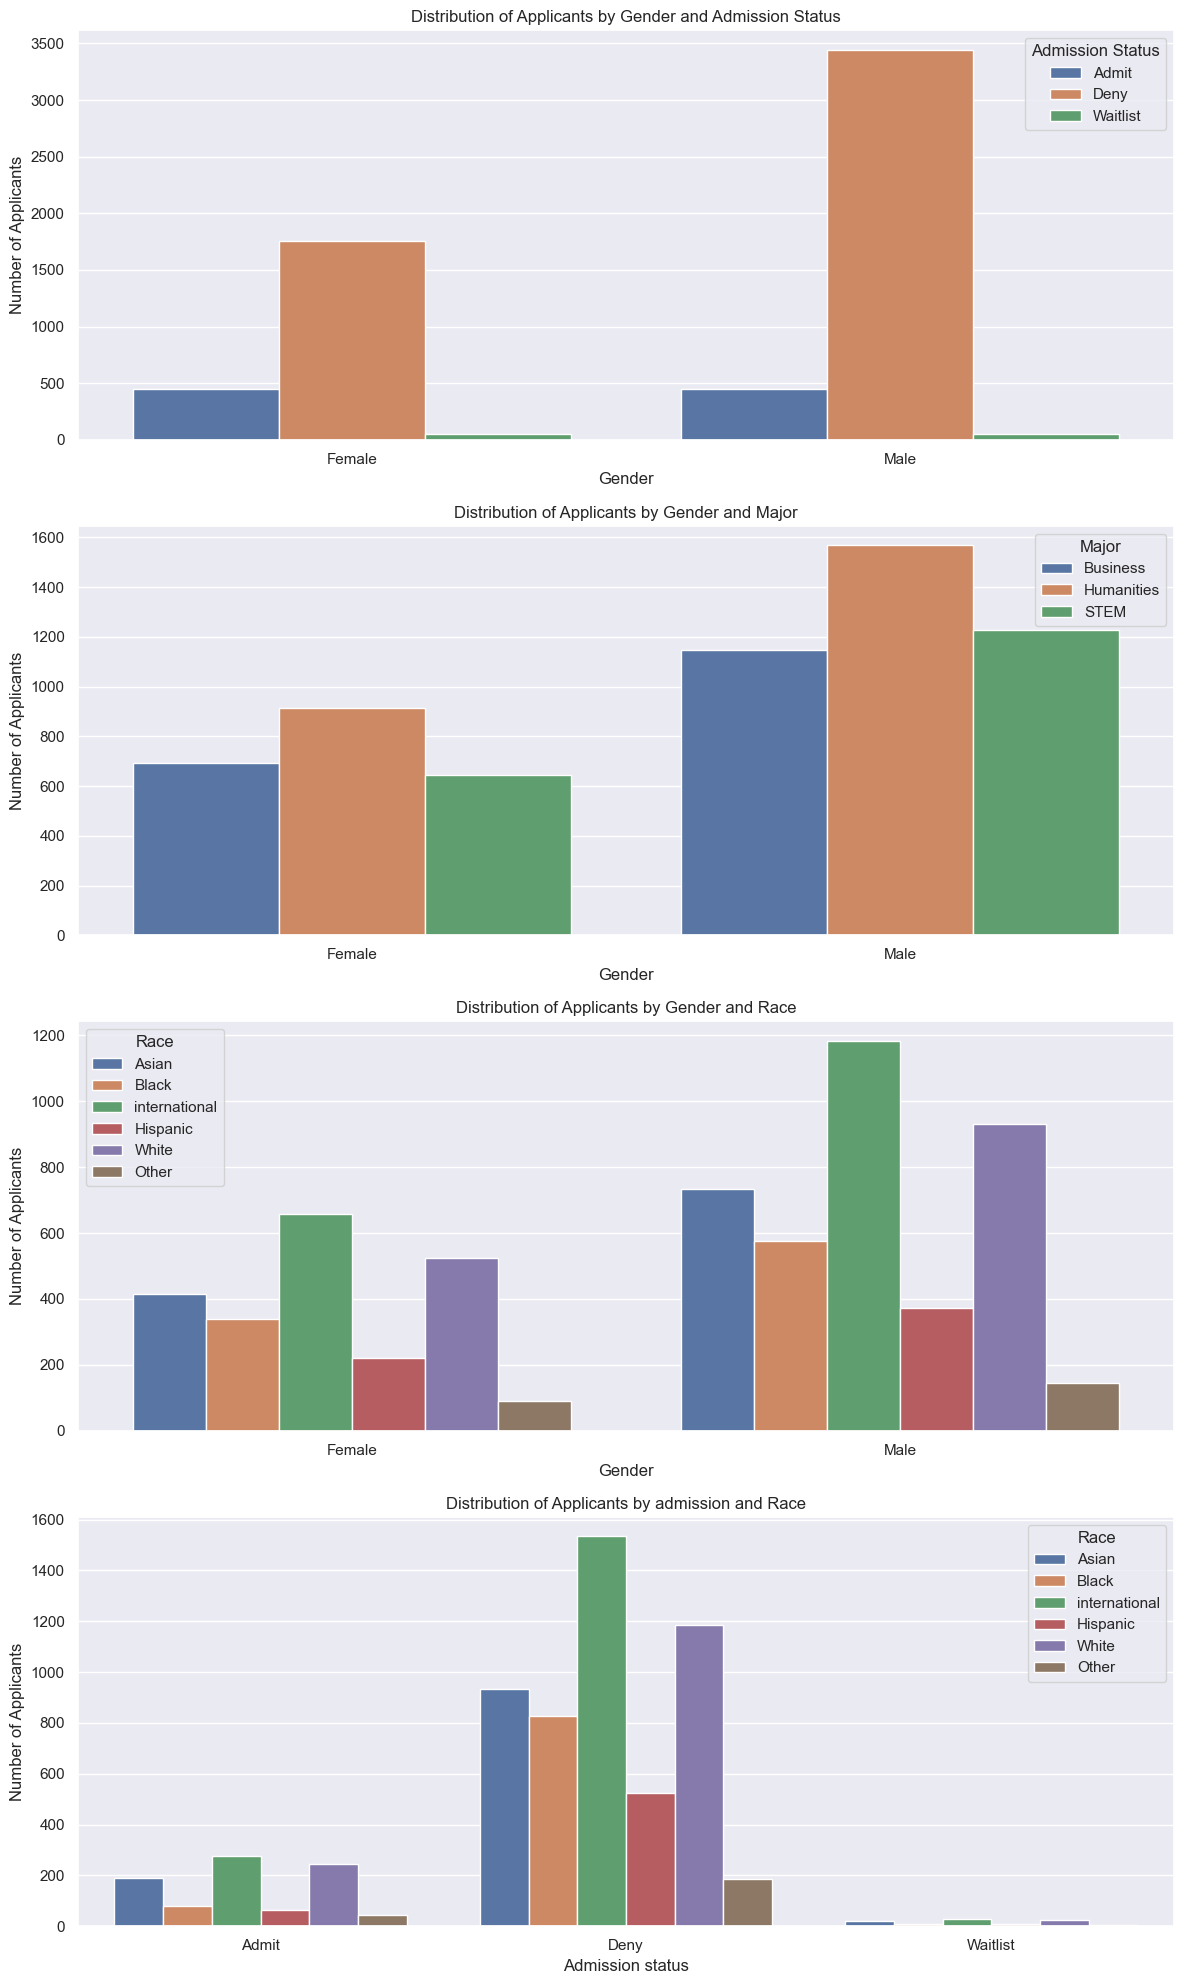

In [21]:


# Create a figure with 4 subplots arranged vertically
fig, axs = plt.subplots(4, 1, figsize=(12, 20))  # 4 rows, 1 column subplots

# Plot 1: Distribution of Applicants by Gender and Admission Status
sns.countplot(data=admission_list, x='gender', hue='admission', ax=axs[0])
axs[0].set_title("Distribution of Applicants by Gender and Admission Status")
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Number of Applicants")
axs[0].legend(title='Admission Status')

# Plot 2: Distribution of Applicants by Gender and Major
sns.countplot(data=admission_list, x='gender', hue='major', ax=axs[1])
axs[1].set_title("Distribution of Applicants by Gender and Major")
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Number of Applicants")
axs[1].legend(title='Major')

# Plot 3: Distribution of Applicants by Gender and Race
sns.countplot(data=admission_list, x='gender', hue='race', ax=axs[2])
axs[2].set_title("Distribution of Applicants by Gender and Race")
axs[2].set_xlabel("Gender")
axs[2].set_ylabel("Number of Applicants")
axs[2].legend(title='Race')

# Plot 4: Distribution of Applicants by Gender and Race (Repeated)
sns.countplot(data=admission_list, x='admission', hue='race', ax=axs[3])
axs[3].set_title("Distribution of Applicants by admission and Race")
axs[3].set_xlabel("Admission status")
axs[3].set_ylabel("Number of Applicants")
axs[3].legend(title='Race')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


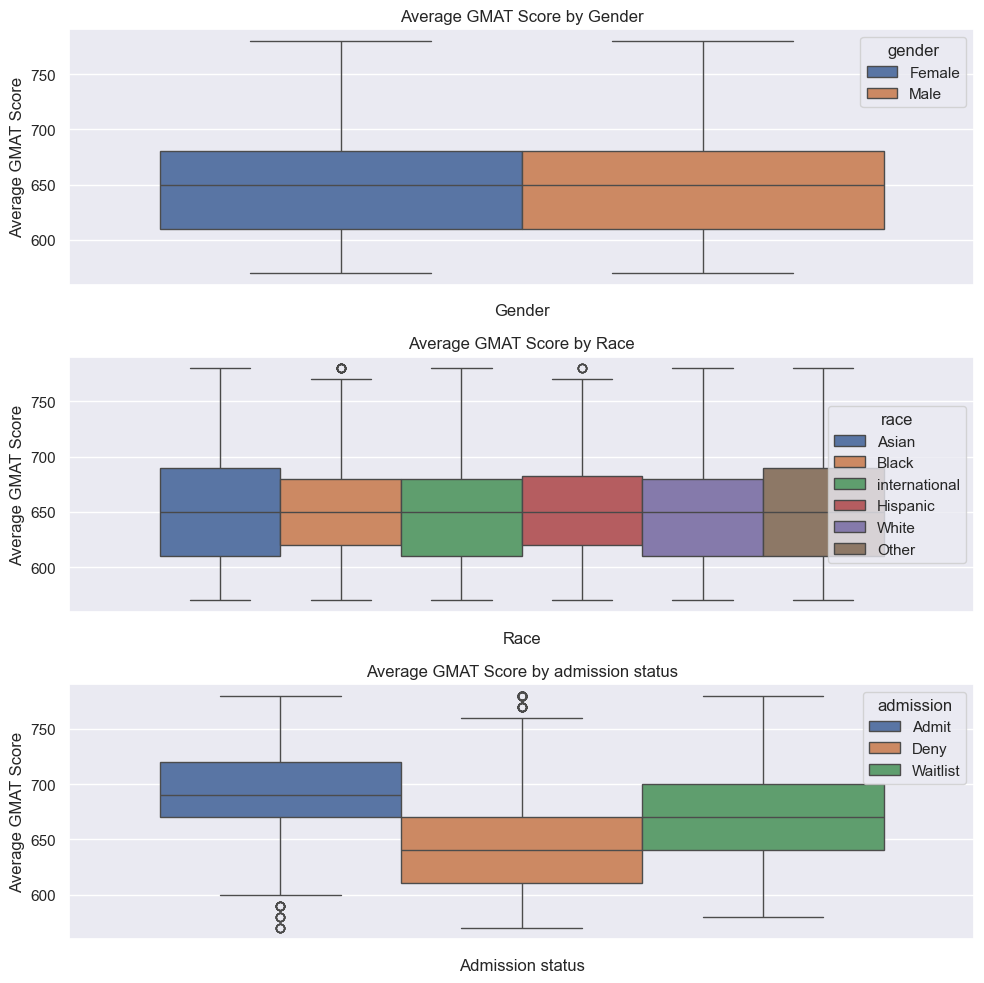

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 10))  # 3 rows, 1 column subplots

# Plot 1: Average GMAT score by gender with distinct color
sns.boxplot(data=admission_list, hue = 'gender', y='gmat', ax=axs[0], legend = True)
axs[0].set_title("Average GMAT Score by Gender")
axs[0].set_xlabel("Gender")
axs[0].set_ylabel("Average GMAT Score")

# Plot 2: Average GMAT score by race with distinct color
sns.boxplot(data=admission_list, hue='race', y='gmat', ax=axs[1], legend = True)
axs[1].set_title("Average GMAT Score by Race")
axs[1].set_xlabel("Race")
axs[1].set_ylabel("Average GMAT Score")

# Plot 2: Average GMAT score by  applications granted
sns.boxplot(data=admission_list, hue='admission', y='gmat', ax=axs[2], legend = True)
axs[2].set_title("Average GMAT Score by admission status")
axs[2].set_xlabel("Admission status")
axs[2].set_ylabel("Average GMAT Score")

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


In [23]:
admn_list = admission_list.copy()
admn_list.drop(['international','application_id'] , axis=1,inplace= True)


admn_list

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny
...,...,...,...,...,...,...,...,...
6189,Male,3.49,Business,White,640.0,5.0,Other,Deny
6190,Male,3.18,STEM,Black,670.0,4.0,Consulting,Deny
6191,Female,3.22,Business,international,680.0,5.0,Health Care,Admit
6192,Male,3.36,Business,international,590.0,5.0,Other,Deny


Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

In [24]:
admn_list.cov(numeric_only=True)


,gpa,gmat,work_exp
gpa,0.022965,4.314334,0.000054
gmat,4.314334,2429.985538,-0.050826
work_exp,0.000054,-0.050826,1.065916


## Interpretation

### Diagonal Elements (Variance)
The diagonal elements of the covariance matrix represent the variance of each variable:

- **`gpa`**: Variance is **0.022965**. This means that the GPA values have a **low spread (variance)** around their mean.
- **`gmat`**: Variance is **2429.985538**. This indicates that GMAT scores have a **high spread** around their mean.
- **`work_exp`**: Variance is **1.065916**. This shows that the years of work experience have a **moderate spread** around their mean.

### Off-Diagonal Elements (Covariance)
The off-diagonal elements represent the **covariance** between pairs of variables:

- **Covariance between `gpa` and `gmat` is 4.314334**:
  - This is a **positive value**, indicating that `gpa` and `gmat` tend to increase together. When GPA increases, GMAT scores also tend to increase, and vice versa.high gpa, high  gmat score is achievable.

- **Covariance between `gpa` and `work_exp` is 0.000054**:
  - This is a very small **positive value**, suggesting a **weak positive relationship** between `gpa` and `work_exp`. In practical terms, there is almost no linear relationship between GPA and work experience.

- **Covariance between `gmat` and `work_exp` is -0.050826**:
  - This is a **negative value**, indicating that as `gmat` scores increase, `work_exp` tends to decrease, and vice versa. However, this value is relatively small, so the linear relationship between these variables is weak.


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:

In [25]:
admn_list.corr(numeric_only=True)

,gpa,gmat,work_exp
gpa,1.000000,0.577539,0.000346
gmat,0.577539,1.000000,-0.000999
work_exp,0.000346,-0.000999,1.000000


example of what we get from interpreting the correlation matrix below:

   - High gpa might result in good score for a gmat test

In [26]:
admn_list

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny
...,...,...,...,...,...,...,...,...
6189,Male,3.49,Business,White,640.0,5.0,Other,Deny
6190,Male,3.18,STEM,Black,670.0,4.0,Consulting,Deny
6191,Female,3.22,Business,international,680.0,5.0,Health Care,Admit
6192,Male,3.36,Business,international,590.0,5.0,Other,Deny


In [27]:
#highest values is less than 4.0
admission_list['gpa'].sort_values(ascending=False)


248     3.77
5572    3.76
4000    3.76
928     3.74
1186    3.74
        ... 
1697    2.78
1066    2.78
1492    2.73
2345    2.72
4901    2.65
Name: gpa, Length: 6194, dtype: float64

In [28]:
#look out for outliers
numeric_columns = ['gmat',"work_exp"]

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #values below lowerbound and above the upper bound are tagged outliers
    values = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return values




# Detect outliers for each numerical column
for column in numeric_columns:
    answers = detect_outliers_iqr(admn_list, column)
    print(f"Outliers in {column}:")
    print(answers)
    print("\n")



Outliers in gmat:
Empty DataFrame
Columns: [gender, gpa, major, race, gmat, work_exp, work_industry, admission]
Index: []


Outliers in work_exp:
Empty DataFrame
Columns: [gender, gpa, major, race, gmat, work_exp, work_industry, admission]
Index: []




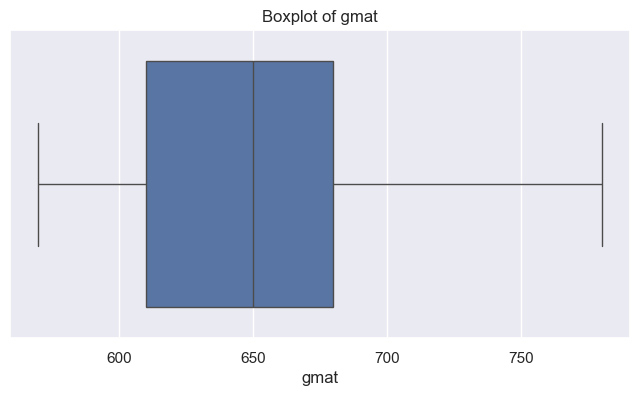

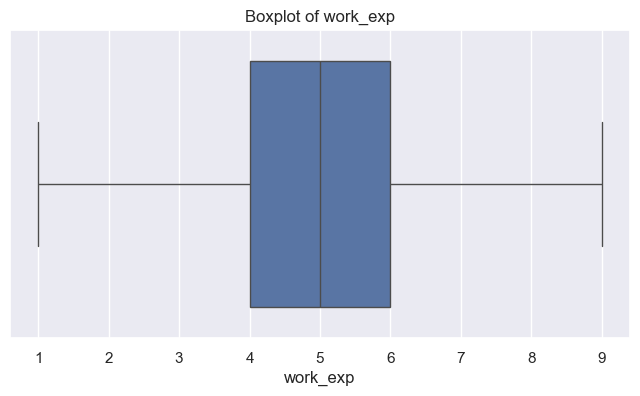

In [29]:
# Create a boxplot for each numerical column to visualize outliers
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=admn_list[column])
    plt.title(f"Boxplot of {column}")
    plt.show()




## Chi-Square Test and P-Value: Understanding Predictive Association

In short, the **chi-square test** and **p-value** help determine if there is a **significant association** between two categorical variables.

### Key Terms:

- **Chi-square (χ²) Statistic**:
  - Measures how much the **observed counts** in the contingency table differ from the **expected counts** (if there was no relationship).
  - A **higher chi-square value** indicates a **stronger association** between the variables.

- **P-value**:
  - Tells us whether the observed association is **statistically significant**.
  - If the **p-value is less than a chosen significance level** (e.g., 0.05), it means the association is significant and unlikely to have occurred by chance.

### Summary:
- **Low P-value (< 0.05)**: Strong evidence of an association between the two variables.
- **High P-value (> 0.05)**: Weak or no evidence of an association between the variables.

In essence, these metrics help determine if the two categorical variables are **independent** or **related**.


## Chi-Square Test and P-Value: Understanding Predictive Association

In short, the **chi-square test** and **p-value** help determine if there is a **significant association** between two categorical variables.

### Key Terms:

- **Chi-square (χ²) Statistic**:
  - Measures how much the **observed counts** in the contingency table differ from the **expected counts** (if there was no relationship).
  - A **higher chi-square value** indicates a **stronger association** between the variables.

- **P-value**:
  - Tells us whether the observed association is **statistically significant**.
  - If the **p-value is less than a chosen significance level** (e.g., 0.05), it means the association is significant and unlikely to have occurred by chance.

### Summary:
- **Low P-value (< 0.05)**: Strong evidence of an association between the two variables.
- **High P-value (> 0.05)**: Weak or no evidence of an association between the variables.

In essence, these metrics help determine if the two categorical variables are **independent** or **related**.


In [30]:
#  Write code to visualize or quantify the predictive strength of every feature in the datase
from scipy.stats import chi2_contingency
# Create a contingency table for gender, 'major', 'race' 'work_industry'
# Write code to determine whether the categorical column has predictive power for the admission column.
gender_contingency_table = pd.crosstab(admn_list['gender'], admn_list['admission'])

major_contingency_table = pd.crosstab(admn_list['major'], admn_list['admission'])

race_contingency_table = pd.crosstab(admn_list['race'], admn_list['admission'])

work_industry_contingency_table = pd.crosstab(admn_list['work_industry'], admn_list['admission'])

# Display the contingency table
print(gender_contingency_table, end="\n\n")


print(major_contingency_table, end="\n\n")


print(race_contingency_table, end="\n\n")


print(work_industry_contingency_table)




admission  Admit  Deny  Waitlist
gender                          
Female       450  1751        50
Male         450  3443        50

admission   Admit  Deny  Waitlist
major                            
Business      270  1546        22
Humanities    367  2073        41
STEM          263  1575        37

admission      Admit  Deny  Waitlist
race                                
Asian            190   935        22
Black             80   826        10
Hispanic          62   526         8
Other             46   187         4
White            244  1186        26
international    278  1534        30

admission              Admit  Deny  Waitlist
work_industry                               
CPG                       20    93         1
Consulting               224  1362        33
Energy                     3    29         0
Financial Services        86   356         9
Health Care               40   286         8
Investment Banking        82   490         8
Investment Management     36   129     

In [31]:
# Perform the chi-square test
# gender_contingency_table, major_contingency_table, race_contingency_table, work_industry_contingency_table

contingency_tables = [
    gender_contingency_table,
    major_contingency_table,
    race_contingency_table,
    work_industry_contingency_table
]

# Iterate over each contingency table
for table in contingency_tables:
    # Calculate chi-square test statistics
    chi2, p, dof, expected = chi2_contingency(table)
    
    # Display the results for each table
    print(f"Chi-square statistic for table:\n{table}")
    print(f"Chi-square value: {chi2:.2f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("\n" + "="*50 + "\n")


Chi-square statistic for table:
admission  Admit  Deny  Waitlist
gender                          
Female       450  1751        50
Male         450  3443        50
Chi-square value: 96.16
P-value: 0.0000
Degrees of Freedom: 2


Chi-square statistic for table:
admission   Admit  Deny  Waitlist
major                            
Business      270  1546        22
Humanities    367  2073        41
STEM          263  1575        37
Chi-square value: 4.03
P-value: 0.4026
Degrees of Freedom: 4


Chi-square statistic for table:
admission      Admit  Deny  Waitlist
race                                
Asian            190   935        22
Black             80   826        10
Hispanic          62   526         8
Other             46   187         4
White            244  1186        26
international    278  1534        30
Chi-square value: 51.70
P-value: 0.0000
Degrees of Freedom: 10


Chi-square statistic for table:
admission              Admit  Deny  Waitlist
work_industry                        

### Interpretation of Chi-Square Results

The chi-square test results help determine whether there is a **significant relationship** between the categorical variables and the `admission` status. Let's analyze each of the contingency tables and their chi-square test results:

1. **Gender vs. Admission Status**:
    - **Chi-square value**: 96.16
    - **P-value**: 0.0000
    - **Degrees of Freedom**: 2
    
    **Interpretation**: The very low p-value (< 0.05) indicates that there is a **significant relationship** between `gender` and `admission` status. This suggests that gender may play a role in predicting admission decisions.

2. **Major vs. Admission Status**:
    - **Chi-square value**: 4.03
    - **P-value**: 0.4026
    - **Degrees of Freedom**: 4
    
    **Interpretation**: The high p-value (> 0.05) indicates that there is **no significant relationship** between `major` and `admission` status. This means that the choice of major does not have a strong predictive association with the admission outcome.

3. **Race vs. Admission Status**:
    - **Chi-square value**: 51.70
    - **P-value**: 0.0000
    - **Degrees of Freedom**: 10
    
    **Interpretation**: The very low p-value (< 0.05) indicates a **significant relationship** between `race` and `admission` status. This suggests that race may have an impact on predicting the admission outcome.

4. **Work Industry vs. Admission Status**:
    - **Chi-square value**: 30.20
    - **P-value**: 0.2593
    - **Degrees of Freedom**: 26
    
    **Interpretation**: The high p-value (> 0.05) suggests **no significant relationship** between `work_industry` and `admission` status. Therefore, work industry does not seem to have a strong predictive association with admission decisions.

### Summary of Predictive Associations for the categorical items
- **Gender** and **Race** show significant associations with `admission` status and may have predictive power.
- **Major** and **Work Industry** do not show significant associations and are unlikely to have predictive power for `admission` status.

These results suggest that you should focus more on **Gender** and **Race** as potential features when building a predictive model for admission decisions, while **Major** and **Work Industry** may not be as impactful.


###  Using ANOVA and T-Tests for Predictive Insights

While **ANOVA** and **t-tests** do not directly determine **predictive power** (which is better assessed using classification models), they help identify if there are **statistically significant differences** in the numerical variable based on the categories. This can be an indicator that the numerical variable might help **differentiate or classify** the categories of the categorical target.


In [32]:
admn_list

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny
...,...,...,...,...,...,...,...,...
6189,Male,3.49,Business,White,640.0,5.0,Other,Deny
6190,Male,3.18,STEM,Black,670.0,4.0,Consulting,Deny
6191,Female,3.22,Business,international,680.0,5.0,Health Care,Admit
6192,Male,3.36,Business,international,590.0,5.0,Other,Deny


In [33]:


# Performing ANOVA to analyze if 'gpa' differs significantly across 'admission' categories
anova_model = ols('gpa ~ C(admission)', data=admn_list).fit()  # Fit the ANOVA model using GPA as the dependent variable
anova_results = sm.stats.anova_lm(anova_model, typ=2)   # Calculate ANOVA table

# Display the ANOVA table with a descriptive message
print("\n=== ANOVA Table: Analysis of GPA across Admission Categories ===")
print(anova_results)



=== ANOVA Table: Analysis of GPA across Admission Categories ===
                  sum_sq      df           F         PR(>F)
C(admission)   12.083220     2.0  287.416661  4.325153e-120
Residual      130.137226  6191.0         NaN            NaN


## Explanation of ANOVA Table

The ANOVA table provides the results of an **Analysis of Variance (ANOVA)** test, which assesses whether there are statistically significant differences between the means of a numerical variable (`gpa`) across different categories of a categorical variable (`admission`). Let’s break down each component of the table to understand what it means:

### ANOVA Table:

| Source        | sum_sq     | df    | F          | PR(>F)          |
|---------------|------------|-------|------------|-----------------|
| C(admission)  | 12.083220  | 2.0   | 287.416661 | 4.325153e-120   |
| Residual      | 130.137226 | 6191.0| NaN        | NaN             |

### Explanation:

- **C(admission)**:
  - This row corresponds to the categorical variable `admission` (e.g., Admit, Deny, Waitlist) used in the model.
  - ANOVA is testing if the mean `gpa` differs significantly across the three levels of `admission`.

- **`sum_sq` (Sum of Squares)**:
  - **C(admission)**: `12.083220` represents the **between-group sum of squares**, indicating the variability in `gpa` that can be explained by differences between the `admission` categories.
  - **Residual**: `130.137226` represents the **within-group sum of squares** (also known as the residual sum of squares), indicating the variability in `gpa` that is not explained by `admission` and is due to other factors or random error.

- **`df` (Degrees of Freedom)**:
  - **C(admission)**: `2.0` represents the **degrees of freedom** for the `admission` variable. It’s calculated as `number of groups - 1`. In this case, there are 3 groups (Admit, Deny, Waitlist), so `df = 3 - 1 = 2`.
  - **Residual**: `6191.0` represents the **degrees of freedom for the residual**. It’s calculated as `total number of observations - number of groups`. In this case, assuming there are 6194 observations, `df = 6194 - 3 = 6191`.

- **`F` (F-Statistic)**:
  - `287.416661` is the F-statistic for the test. The F-statistic is calculated as the ratio of the mean square value of `C(admission)` (between-group variance) to the mean square value of the residual (within-group variance).
  - A higher F-value indicates that there is a greater difference between the group means relative to the variability within the groups.

- **`PR(>F)` (P-Value)**:
  - `4.325153e-120` is the **p-value** corresponding to the F-statistic.
  - This is an extremely small p-value (`4.325153e-120` is equivalent to `0.000...4325` with 119 zeros before the 4), which is far below typical significance levels (e.g., 0.05 or 0.01).
  - This small p-value indicates that we can **reject the null hypothesis**, suggesting that there is a significant difference in the mean `gpa` across the different `admission` categories.

- **Residual**:
  - The Residual row represents the unexplained variability in `gpa` that is not accounted for by the `admission` categories.

### Interpretation:
- The ANOVA test suggests that the mean `gpa` differs significantly across the three admission categories (`Admit`, `Deny`, `Waitlist`).
- The **p-value (`4.325153e-120`)** is extremely small, indicating that it’s very unlikely that the observed differences in GPA are due to random chance.
- Therefore, we conclude that **admission status has a significant effect on the average `gpa`** of applicants.


In [34]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Performing ANOVA to analyze if 'gpa' differs significantly across 'admission' categories
anova_model = ols('gmat ~ C(admission)', data=admn_list).fit()  # Fit the ANOVA model using GPA as the dependent variable
anova_results = sm.stats.anova_lm(anova_model, typ=2)   # Calculate ANOVA table

# Display the ANOVA table with a descriptive message
print("\n=== ANOVA Table: Analysis of Gmat score  across Admission Categories ===")
print(anova_results)


=== ANOVA Table: Analysis of Gmat score  across Admission Categories ===
                    sum_sq      df           F         PR(>F)
C(admission)  1.915040e+06     2.0  451.352929  1.041481e-183
Residual      1.313386e+07  6191.0         NaN            NaN


## ANOVA Table: Analysis of GMAT Score Across Admission Categories

The ANOVA table below shows the results of an Analysis of Variance (ANOVA) test, which examines whether there are statistically significant differences in the **GMAT scores** across different categories of **admission status** (e.g., Admit, Deny, Waitlist). Let's break down each component of the table to understand its meaning:

### ANOVA Table:

| Source       | sum_sq         | df      | F           | PR(>F)          |
|--------------|----------------|---------|-------------|-----------------|
| C(admission) | 1.915040e+06    | 2.0     | 451.352929  | 1.041481e-183   |
| Residual     | 1.313386e+07    | 6191.0  | NaN         | NaN             |

### Explanation of Each Component

1. **`C(admission)`**:
   - This row corresponds to the **categorical variable** `admission` (e.g., Admit, Deny, Waitlist) used in the model.
   - The ANOVA test is evaluating whether the mean `GMAT scores` differ significantly across the three levels of `admission`.

2. **`sum_sq` (Sum of Squares)**:
   - **`C(admission)`:** `1.915040e+06` represents the **between-group sum of squares**, which indicates the variability in `GMAT scores` that can be explained by the differences between the `admission` categories.
   - **Residual:** `1.313386e+07` represents the **within-group sum of squares** (also known as the residual sum of squares), which indicates the variability in `GMAT scores` that is not explained by `admission` and is due to other factors or random error.

3. **`df` (Degrees of Freedom)**:
   - **`C(admission)`:** `2.0` represents the degrees of freedom for the `admission` variable. It’s calculated as `number of groups - 1`. In this case, there are 3 groups (Admit, Deny, Waitlist), so `df = 3 - 1 = 2`.
   - **Residual:** `6191.0` represents the degrees of freedom for the residual. It’s calculated as `total number of observations - number of groups`. In this case, assuming there are 6194 observations, `df = 6194 - 3 = 6191`.

4. **`F` (F-Statistic)**:
   - `451.352929` is the F-statistic for the test. The F-statistic is calculated as the ratio of the mean square value of `C(admission)` (between-group variance) to the mean square value of the residual (within-group variance).
   - A higher F-value indicates a greater difference between the group means relative to the variability within the groups.

5. **`PR(>F)` (P-Value)**:
   - `1.041481e-183` is the **p-value** corresponding to the F-statistic.
   - This is an extremely small p-value (essentially zero), which is far below typical significance levels (e.g., 0.05 or 0.01).
   - This small p-value indicates that we can **reject the null hypothesis**, suggesting that there is a significant difference in the mean `GMAT scores` across the different `admission` categories.

6. **Residual**:
   - The Residual row represents the unexplained variability in `GMAT scores` that is not accounted for by the `admission` categories.

### Interpretation

- The **ANOVA test** suggests that the mean `GMAT scores` differ significantly across the three admission categories (`Admit`, `Deny`, `Waitlist`).
- The **p-value** of `1.041481e-183` indicates that the observed differences in GMAT scores are highly unlikely to be due to random chance.
- Therefore, we conclude that **admission status has a significant effect on the average GMAT score** of applicants.

### Summary

The results suggest that `admission status` is a good indicator of variations in `GMAT scores` among applicants. This means that different admission outcomes are associated with different average GMAT scores. Further analysis, such as post-hoc tests, can identify which specific admission groups show significant differences in GMAT scores.


In [35]:
#Calculate the mean GMAT score for each admission category
admit_mean = admn_list[admn_list['admission'] == 'Admit']['gmat'].mean()
deny_mean = admn_list[admn_list['admission'] == 'Deny']['gmat'].mean()
waitlist_mean = admn_list[admn_list['admission'] == 'Waitlist']['gmat'].mean()

# Print the mean GMAT scores for each admission category
print(f"Mean GMAT score for Admitted candidates is : {admit_mean:.2f}")
print(f"Mean GMAT score for Denied applicant : {deny_mean:.2f}")
print(f"Mean GMAT score for applicants on the Waitlist: {waitlist_mean:.2f}")

Mean GMAT score for Admitted candidates is : 692.73
Mean GMAT score for Denied applicant : 643.44
Mean GMAT score for applicants on the Waitlist: 673.60


In [36]:
admission_list.isnull().sum()

application_id    0
gender            0
international     0
gpa               0
major             0
race              0
gmat              0
work_exp          0
work_industry     0
admission         0
dtype: int64

## Session 3 - Splitting and Transforming the Data

In this session we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to split and transform the data, a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script.

In [37]:
admission_list.admission.value_counts()

admission
Deny        5194
Admit        900
Waitlist     100
Name: count, dtype: int64

In [38]:
admission_list.head(5)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,3,Female,True,3.30,Business,international,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [39]:
#dropping this because it's similar to the race, the race already has a column for  describing international applicants and also the application_id
admission_list.drop(['international','application_id'], axis = 1, inplace = True)

In [40]:
admission_list.head(5)

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [41]:

from io import StringIO  # Allows to convert dataframe to a string buffer


# Define the bucket name and the destination file name in S3, including the folder path
bucket_name = bucket  # Replace with your S3 bucket name
folder_name = 'admission'  # Replace with your desired folder name in S3
sub_folder_name = 'data'
file_name = 'wharton_admission_list.csv'   # The name of the file to be saved in S3

# Combine folder name and file name to create the full path in S3
s3_file_path = f'{folder_name}/{sub_folder_name}/{file_name}'

# Convert the DataFrame to a CSV string buffer
csv_buffer = StringIO()
admission_list.to_csv(csv_buffer, index=False)  # Convert DataFrame to CSV format and store in buffer

# Create a session with boto3 and specify your AWS credentials
s3_resource = boto3.resource('s3')

# Upload the CSV file to the specified S3 bucket in the specified folder
s3_resource.Object(bucket_name, s3_file_path).put(Body=csv_buffer.getvalue())

print(f"File '{file_name}' successfully uploaded to folder '{folder_name}' in bucket '{bucket_name}'!")


File 'wharton_admission_list.csv' successfully uploaded to folder 'admission' in bucket 'admission-list'!


We will store the script in a folder called **processing** and add it to the system path so we can later import it as a module.

In [42]:
CODE_FOLDER

PosixPath('code')

In [43]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)

In [44]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    # Target transformer for admission (binary classification)
    target_transformer = ColumnTransformer(
        transformers=[("admission", OrdinalEncoder(), ["admission"])],
        remainder='passthrough'
    )

    # Numeric transformer pipeline
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    # Categorical transformer pipeline
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(drop='first', sparse=False),
    )

    # Define categorical columns correctly
    cat_columns = ['gender', 'major', 'race', 'work_industry']
    
    # Define numeric columns explicitly
    num_columns = ['gpa', 'gmat', 'work_exp']

    # Combined feature transformer
    features_transformer = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, num_columns),
            ("categorical", categorical_transformer, cat_columns),
        ],
    )

    # Split data 
    df_train, df_validation, df_test = _split_data(df)

    # Save baselines
    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    # Transform targets
    y_train = target_transformer.fit_transform(
        df_train[['admission']]
    )
    y_validation = target_transformer.transform(
        df_validation[['admission']]
    )
    y_test = target_transformer.transform(
        df_test[['admission']]
    )

    # Drop the target column 
    df_train = df_train.drop("admission", axis=1)
    df_validation = df_validation.drop("admission", axis=1)
    df_test = df_test.drop("admission", axis=1)

    # Transform features
    X_train = features_transformer.fit_transform(df_train)
    X_validation = features_transformer.transform(df_validation)
    X_test = features_transformer.transform(df_test)

    # Save the processed data
    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )

    # Save the transformers
    _save_model(base_directory, target_transformer, features_transformer)

def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files."""
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"There are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)
    return df.sample(frac=1, random_state=42)




def _split_data(df):
    """Split the data into train, validation, and test."""
    # Step 1: Split the data into train (70%) and temp (30%) with stratification
    df_train, temp = train_test_split(df, test_size=0.3, stratify=df['admission'], random_state=42)

    # Step 2: Split the temp data equally into validation (15%) and test (15%) with stratification
    df_validation, df_test = train_test_split(temp, test_size=0.5, stratify=temp['admission'], random_state=42)


    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline durning monitoring to
    determine the quality of the data that the model receives
    when deployed and the target wont be supplied by the users.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("admission", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    #create a temporary folder to store, that disappears after the model is moved
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")
        
        #create a model folder in aws directory 
        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
             #copy the model from the temp folder to the model path
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")


Overwriting code/processing/script.py


### Step 2 - Caching Configuration

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step.


Let's define a caching policy that we'll reuse on every step:

In [45]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

### Step 3 - Pipeline Configuration

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter

In [46]:
S3_LOCATION = f"s3://{bucket}/admission"
S3_LOCATION

's3://admission-list/admission'

In [47]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

dataset_location

ParameterString(name='dataset_location', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='s3://admission-list/admission/data')

### Step 4 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline to run the script that will split and transform the data.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch a Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK.



In [48]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

Let's now define the Processing Step that we'll use in the pipeline.

This step will specify the list of inputs that we'll access from the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [49]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/gabriel/Documents/ML_school/ml.school/.venv/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Step 5 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does

In [50]:
from sagemaker.workflow.pipeline import Pipeline

session1_preprocess_pipeline = Pipeline(
    name="session1-pipeline-preprocess",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session1_preprocess_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:025066244860:pipeline/session1-pipeline-preprocess',
 'ResponseMetadata': {'RequestId': 'db83d8d7-7c77-4bbc-b548-7716cbb99d8f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'db83d8d7-7c77-4bbc-b548-7716cbb99d8f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Sun, 03 Nov 2024 20:20:22 GMT'},
  'RetryAttempts': 0}}

In [51]:
# %%script false --no-raise-error


session1_preprocess_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session1-pipeline-preprocess/execution/sqy17teghxl6', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Session 4 - Training the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [step to train a model](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). Check [Train a Model with TensorFlow](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#train-a-model-with-tensorflow) for more information about training a model with TensorFlow.



We'll also introduce experiment tracking using [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github).


### Step 1 - Creating the Training Script

Let's create the training script. This script is responsible for training a neural network using the train data, validating the model, and saving it so we can later use it.neural network because of the low numbers of the admitted and waiting list,also going to use a cost sensitive to help the neural network focus on the minority of the imbalanced data set.

# Class Weight Balancing Approaches

### 1. **Balanced Weight Approach**
- This approach gives more aggressive weighting for the minority classes.
- The class weights are calculated as the total number of samples divided by the number of samples in each class.

**Distribution**: Admit (900), Deny (5194), Waitlist (100)

Example:

Total samples = 900 + 5194 + 100

Class weights:
- Admit: total_samples / 900 = ~6.88
- Deny: total_samples / 5194 = ~1.19
- Waitlist: total_samples / 100 = ~61.94

**Purpose**: Useful when you want to emphasize the minority class more aggressively in your model training.

---

### 2. **Inverse Frequency Weighting**
- This method emphasizes minority classes even more by setting the weight of each class relative to the most frequent class (inversely proportional to class frequency).

**Distribution**: Admit (900), Deny (5194), Waitlist (100)

Example:

Max samples = 5194

Class weights:
- Admit: 5194 / 900 = 5.77
- Deny: 5194 / 5194 = 1.00
- Waitlist: 5194 / 100 = 51.94

**Purpose**: This method is particularly useful when you want a stronger correction for imbalanced classes by heavily emphasizing minority classes.

---

### 3. **Square Root Balanced Approach**
- A more moderate strategy that calculates class weights as the square root of the ratio between the most frequent class and each class.
- This method reduces the risk of overfitting by applying moderate weighting.

**Distribution**: Admit (900), Deny (5194), Waitlist (100)

Example:

Max samples = 5194

Class weights:
- Admit: sqrt(5194 / 900) = 2.40
- Deny: sqrt(5194 / 5194) = 1.00
- Waitlist: sqrt(5194 / 100) = 7.21

**Purpose**: Provides more balanced weighting without overly penalizing the majority class, helping prevent overfitting to minority classes.


In [52]:

(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)

In [53]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile
from pathlib import Path
from comet_ml import Experiment

import keras
import numpy as np
import pandas as pd
from math import sqrt 

from keras import Input
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential  # Removed trailing comma
from keras.optimizers import Adam, SGD
from packaging import version
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,  # Added missing learning_rate parameter
    ):
    
    print(f"Keras version: {keras.__version__}")

    # load the train from the preprocessing step
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    print(f"Input shape for training: {X_train.shape}")
    print(f"Input shape for validation: {X_validation.shape}")

    # Define class weights - Fixed undefined 'y' variable
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),  # Changed y to y_train
        y=y_train  # Changed y to y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    class_weight_dict[2] *= 1.5

    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "admission.keras"
    )
    
    # Build model - Fixed undefined X variable
    model = Sequential([
            Input(shape=(X_train.shape[1],)),  # Changed X to X_train
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation="relu"),
            BatchNormalization(),
            Dropout(0.15),
            Dense(32, activation="relu"),
            BatchNormalization(),
            Dense(3, activation="softmax"),
        ])

    model.compile(
            optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=model_filepath,
                monitor='val_loss',
                save_best_only=True
            )
        ]

    # Fixed variable names
    model.fit(
        X_train,
        y_train,
        validation_data=(X_validation, y_validation),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,  # Fixed variable name
        callbacks=callbacks,  # Fixed variable name
        verbose=1,
    )

    model.save(model_filepath)

    predictions = np.argmax(model.predict(X_validation), axis=-1)

    val_accuracy = accuracy_score(y_validation, predictions)
    val_precision = precision_score(y_validation, predictions, average='weighted')
    val_recall = recall_score(y_validation, predictions, average='weighted')

    print(f"Validation accuracy: {val_accuracy}")
    print(f"Validation precision: {val_precision}")
    print(f"Validation recall: {val_recall}")

    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)
    
    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
                "accuracy": val_accuracy,
                "precision": val_precision,
                "recall": val_recall,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(
            y_validation.astype(int), predictions.astype(int)
        )
        experiment.log_model("admission_model", model_filepath.as_posix())

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)  # This argument is passed from the pipeline
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--learning_rate", type=float, default=0.001)
    
    args, _ = parser.parse_known_args()

    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", "{}"))
    job_name = training_env.get("job_name", None) if training_env else None

    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        model_directory=os.environ["SM_MODEL_DIR"],
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,  # Pass epochs from args
        batch_size=args.batch_size,
        learning_rate = args.learning_rate
    )

Overwriting code/training/script.py


### Step 2 - Setting up the Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

SageMaker manages the infrastructure of a Training Job. It provisions resources for the duration of the job, and cleans up when it completes. The Training Container image that SageMaker uses to run a Training Job can either be a SageMaker built-in image or a custom image.


The [Available Deep Learning Container Images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md) page contains the list of available containers for each region.

Our training script uses Comet to track metrics from the Training Job. We need to create a requirements.txt file to install the Comet library in the training container.


In [54]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet_ml

Overwriting code/training/requirements.txt


SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, I will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before.

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

I am going to use [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github) and [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) to track metrics from the Training Job. SageMaker Experiments will use the list of metric definitions to decide which metrics to track and how to parse them from the Training Job logs. For more information, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).

Here are the environment variables we need to set on the traininng container:

-   `COMET_API_KEY`: This is your  API key.
-   `COMET_PROJECT_NAME`: The name of the project where you want to track the experiments.


In [55]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 16,
        "learning_rate": 0.01
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

Now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

This step will receive the train and validation split from the preprocessing step as inputs.

Here, i use three input channels, `train`, `validation`, and `pipeline`. SageMaker will automatically create an environment variable corresponding to each of these channels following the format `SM_CHANNEL_[channel_name]`:

-   `SM_CHANNEL_TRAIN`: This environment variable will contain the path to the training data coming from the preprocessing step.
-   `SM_CHANNEL_VALIDATION`: This environment variable will contain the path to the validation data coming from the preprocessing step.
-   `SM_CHANNEL_PIPELINE`: This environment variable will contain the path to the transformation pipeline that we saved in the preprocessing step.

Notice that i create a function that we can later reuse to create a training step using a different estimator.


In [56]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model-wharton",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

### Step 3 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [57]:
#true means im running all on my machine
LOCAL_MODE = False

In [58]:
#already cached the preprocessing step and im also importing 
session2_train_pipeline = Pipeline(
    name="session2-train-model-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session2_train_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:025066244860:pipeline/session2-train-model-pipeline',
 'ResponseMetadata': {'RequestId': '09c7fd7b-7a47-41b7-bdf6-b96422417dbf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '09c7fd7b-7a47-41b7-bdf6-b96422417dbf',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Sun, 03 Nov 2024 20:21:06 GMT'},
  'RetryAttempts': 0}}

In [59]:
session2_train_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session2-train-model-pipeline/execution/mq9qnmtlamzb', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

### STEP 5 - Modify the Script

- The training script trains the model using a hard-coded learning rate value. I modify the script to accept the learning rate from outside the training script, hence can adjust the neural netwwork training

- Modifying  the training script to implement a 5-fold cross-validation strategy. I modify the pipeline so the training script receives the entire dataset instead of separate training and validation sets.

- I currently define the number of epochs to train the model as a constant that we pass to the Estimator using the list of hyperparameters. I replace this constant with a new Pipeline Parameter named training_epochs.

- The current Training Step downloads the data from the specified S3 location and uploads it to the training container. I modify the Training Step to use SageMaker's Pipe input mode to stream the data directly from S3 to the training container. This will reduce the time it takes to start the Training Job and reduce the amount of disk space needed in the training container. 

In [60]:
# Define the 85% reduced number of samples for each class
# 70 train, 15% validation, 15% test
samples_per_class_85 = {
    0: 765,    # Admit (85% of 900)
    1: 4414.9, # Deny (85% of 5194)
    2: 85      # Waitlist (85% of 100)
}

# Max samples (Deny class)
max_samples = max(samples_per_class_85.values())

# Calculate class weights using the square root approach
class_weights_85 = {
    class_label: np.sqrt(max_samples / count)
    for class_label, count in samples_per_class_85.items()
}

class_weights_85


# Define the 85% reduced number of samples for each class 70% train and 15% validation data, so 85
admit_samples_85 = 765  # class 0
deny_samples_85 = 4415  # class 1
waitlist_samples_85 = 85  # class 2

# Max samples (Deny class)
max_samples = deny_samples_85

# Calculate the class weights using Inverse Frequency Weighting
class_weights = {
    0: max_samples / admit_samples_85 * 1.5,      # Admit: 4414.9 / 765
    1: max_samples / deny_samples_85,       # Deny: 4414.9 / 4414.9
    2: max_samples / waitlist_samples_85 *2.0    # Waitlist: 4414.9 / 85
}

# Print the class weights
print(f"Class Weights based on 85% values: {class_weights}")

Class Weights based on 85% values: {0: 8.656862745098039, 1: 1.0, 2: 103.88235294117646}


In [61]:
%%writefile {CODE_FOLDER}/training/script_cv.py
# | filename: script_cv.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile
from pathlib import Path
from comet_ml import Experiment
from math import sqrt 

import keras
from keras.regularizers import l2
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from packaging import version
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs,
    batch_size=16,
    learning_rate=0.001
):
    print(f"Keras version: {keras.__version__}")

    # Load and concatenate training and validation datasets
    X_train = pd.read_csv(Path(train_path) / "train.csv", header=None)
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)
    
    X_validation = pd.read_csv(Path(validation_path) / "validation.csv", header=None)
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    # Combine training and validation data
    X = pd.concat([X_train, X_validation], axis=0, ignore_index=True)
    y = pd.concat([y_train, y_validation], axis=0, ignore_index=True)

    print("X shape:", X.shape)
    print("Input dimensions:", X.shape[1])

    # Compute balanced class weights
    #class_weights = compute_class_weight(
        #class_weight='balanced',
        #classes=np.unique(y),
        #y=y
    # )
    #class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    # Extra boost for waitlist class

    #class_weight_dict[2] *= 2.0  # Waitlist
    #class_weight_dict[0] *= 1.5  # Admit

    # Define the 85% reduced number of samples for each class 70% train and 15% validation data, so 85
    admit_samples_85 = 765  # class 0
    deny_samples_85 = 4415  # class 1
    waitlist_samples_85 = 85  # class 2
    
    # Max samples (Deny class)
    max_samples = deny_samples_85
    
    # Calculate the class weights using Inverse Frequency Weighting
    class_weight_dict = {
        0: max_samples / admit_samples_85,      # Admit: 4414.9 / 765
        1: max_samples / deny_samples_85,       # Deny: 4414.9 / 4414.9
        2: max_samples / waitlist_samples_85 *2.0    # Waitlist: 4414.9 / 85
    }

    # Initialize StratifiedKFold for better class distribution
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Save the final model
    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "admission.keras"
    )

    # List to store accuracy for each fold
    fold_accuracies = []

    # Perform stratified cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f"\nTraining on fold {fold}")
        
        # Split the data into training and validation sets for this fold
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Create the enhanced model
        model = Sequential([
            Input(shape=(X.shape[1],)),
            Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dense(3, activation="softmax"),
        ])

        # Compile with Adam optimizer and gradient clipping
        model.compile(
            optimizer=RMSprop(learning_rate=learning_rate, clipnorm=1.0),
            loss="sparse_categorical_crossentropy",  
            metrics=["accuracy"]
        )

        # Enhanced callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-6
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=model_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max'
            )
        ]

        # Train the model
        model.fit(
            X_train_fold,
            y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=callbacks,
            verbose=2
        )

        # Evaluate the model on the validation set for this fold
        val_predictions = np.argmax(model.predict(X_val_fold), axis=-1)
        fold_accuracy = accuracy_score(y_val_fold, val_predictions)
        fold_accuracies.append(fold_accuracy)
        print(f"Fold {fold} validation accuracy: {fold_accuracy}")

    # Calculate mean validation accuracy across all folds
    mean_val_accuracy = np.mean(fold_accuracies)
    print(f"\nMean validation accuracy using cross-validation: {mean_val_accuracy}")

    # Retrain the model on the entire dataset
    print("\nTraining final model on entire dataset")
    final_model = Sequential([
            Input(shape=(X.shape[1],)),
            Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dense(3, activation="softmax"),
            ])

    final_model.compile(
        optimizer=RMSprop(learning_rate=learning_rate, clipnorm=1.0),
        loss="sparse_categorical_crossentropy",  
        metrics=["accuracy"]
    )

    # Train the final model with a validation split
    history = final_model.fit(
        X,
        y,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        validation_split=0.2,  # Use 20% of data for validation
        callbacks=callbacks,
        verbose=1
    )

    # Save the final model using model.save()
    final_model.save(model_filepath)

    # Evaluate the model on the entire dataset again
    print("\nEvaluating final model on entire dataset")
    final_predictions = np.argmax(final_model.predict(X), axis=-1)
    final_accuracy = accuracy_score(y, final_predictions)
    final_precision = precision_score(y, final_predictions, average='weighted')
    final_recall = recall_score(y, final_predictions, average='weighted')

    print(f"\nFinal model metrics:")
    print(f"Final model accuracy on entire dataset: {final_accuracy:.4f}")
    print(f"Final model precision on entire dataset: {final_precision:.4f}")
    print(f"Final model recall on entire dataset: {final_recall:.4f}")

    # Save the transformation pipelines inside the model directory
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    # Log metrics to Comet.ml if experiment is set up
    if experiment:
        experiment.log_parameters({
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "class_weights": class_weight_dict
        })
        experiment.log_dataset_hash(X)
        experiment.log_confusion_matrix(
            y.astype(int), final_predictions.astype(int)
        )
        experiment.log_model("admission", model_filepath.as_posix())
        experiment.log_metric("mean_cv_accuracy", mean_val_accuracy)
        experiment.log_metric("final_model_accuracy", final_accuracy)
        experiment.log_metric("final_model_precision", final_precision)
        experiment.log_metric("final_model_recall", final_recall)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--learning_rate", type=float, default=0.001)
    
    args, _ = parser.parse_known_args()

    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", "{}"))
    job_name = training_env.get("job_name", None) if training_env else None

    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        model_directory=os.environ["SM_MODEL_DIR"],
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate
    )


Overwriting code/training/script_cv.py


In [62]:
from sagemaker.workflow.parameters import ParameterInteger
from sagemaker.tensorflow import TensorFlow
# Define pipeline parameter for training epochs
training_epochs = ParameterInteger(name="training_epochs", default_value=50)

estimator = TensorFlow(
    base_job_name="training02",
    entry_point="script_cv.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": training_epochs, #or add a value if not wanting to use the parameter interger training_epochs
        "batch_size": 16,
        "learning_rate": 0.001
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tell
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
    #input_mode="Pipe"  # Set the input mode to 'Pipe'
)

In [63]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="training_cross_validation",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step_cross_validation = create_training_step(estimator)

In [64]:
session2_cross_validation_pipeline = Pipeline(
    name="session2-cross-pipeline",
    parameters=[dataset_location, training_epochs],
    steps=[
        preprocessing_step,
        train_model_step_cross_validation,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session2_cross_validation_pipeline.upsert(role_arn=role)


# To start the pipeline with a custom number of epochs
session2_cross_validation_pipeline.start(parameters={"training_epochs": 50})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session2-cross-pipeline/execution/ch9yn4f2ts1r', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Session 5 - Tuning the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [step to tune the model](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) using a Hyperparameter Tuning Job.

### Step 1 - Enabling Tuning

Since we could use the Training of the Tuning Step to create a model, we'll define a constant to indicate which approach we want to run. Notice that the Tuning Step is not supported in Local Mode.




In [65]:
USE_TUNING_STEP = False 

### Step 2 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.The default job is the bayesian, but i do a grid search strategy

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. It specifies whether it should minimize the metric or maximize it. In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

-   `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
-   `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.


In [66]:
from sagemaker.workflow.parameters import ParameterInteger
from sagemaker.tensorflow import TensorFlow
# Define pipeline parameter for training epochs


hyperparameter_estimator = TensorFlow(
    base_job_name="training02",
    entry_point="script_cv.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50, #or add a value if not wanting to use the parameter interger training_epochs
        "batch_size": 16,
        "learning_rate": 0.001
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tell
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

In [67]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import CategoricalParameter

#estimator as defined above
tuner = HyperparameterTuner(
    hyperparameter_estimator, 
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "batch_size": CategoricalParameter([16, 32]),
        "learning_rate": CategoricalParameter([0.1,0.01, 0.001]),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=6,
    max_parallel_jobs=2,
    strategy="Grid",
)

In [68]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

### Step 3 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

The tune-model-step uses the esimator that has access to the script_cv. py file and all the configuration

In [69]:
session3_tune_pipeline = Pipeline(
    name="session3-hyperparameter-tuning-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_tune_pipeline.upsert(role_arn=role)
session3_tune_pipeline.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session3-hyperparameter-tuning-pipeline/execution/l31ld8106qaa', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

Top Parameter as selected by the job is the `BATCH SIZE 16` and `LEARNING RATE 0.001`

## Session 6 - Evaluating the Model with both models

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate the model using the holdout set we created during the preprocessing step.

### Step 1 - Creating the Evaluation Script

We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to execute the evaluation script.

This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

first is to ensure the  IAM Role Has Proper Permissions

In [70]:
%%writefile {CODE_FOLDER}/evaluation/script.py
# | filename: script.py
# | code-line-numbers: true


import json
import tarfile
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import keras
from comet_ml import Experiment


def evaluate(train_model_path, tune_model_path, test_path, output_path, experiment):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)
    
    # Load both models
    with tarfile.open(Path(train_model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(train_model_path))
    train_model = keras.models.load_model(Path(train_model_path) / "001")
    
    with tarfile.open(Path(tune_model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(tune_model_path))
    tune_model = keras.models.load_model(Path(tune_model_path) / "001")
    
    # Evaluate both models
    train_predictions = np.argmax(train_model.predict(X_test), axis=-1)
    tune_predictions = np.argmax(tune_model.predict(X_test), axis=-1)
    
    # Overall metrics for both models
    train_accuracy = accuracy_score(y_test, train_predictions)
    train_precision = precision_score(y_test, train_predictions, average='weighted')
    train_recall = recall_score(y_test, train_predictions, average='weighted')
    
    tune_accuracy = accuracy_score(y_test, tune_predictions)
    tune_precision = precision_score(y_test, tune_predictions, average='weighted')
    tune_recall = recall_score(y_test, tune_predictions, average='weighted')
    
    print(f"Training model - Overall test accuracy: {train_accuracy}")
    print(f"Training model - Overall test precision: {train_precision}")
    print(f"Training model - Overall test recall: {train_recall}")
    
    print(f"Tuning model - Overall test accuracy: {tune_accuracy}")
    print(f"Tuning model - Overall test precision: {tune_precision}")
    print(f"Tuning model - Overall test recall: {tune_recall}")
    
    # Per-class metrics for both models, as defined in pre-processing
    class_names = ['Admit', 'Deny', 'Waitlist']
    train_cm = confusion_matrix(y_test, train_predictions)
    tune_cm = confusion_matrix(y_test, tune_predictions)
    
    print("Training model - Confusion Matrix:\n", train_cm)
    print("Tuning model - Confusion Matrix:\n", tune_cm)
    
    train_class_metrics = {}
    tune_class_metrics = {}
    for i, class_name in enumerate(class_names):
        # Training model metrics
        train_class_accuracy = train_cm[i, i] / train_cm[i].sum() if train_cm[i].sum() > 0 else 0
        train_class_precision = precision_score(y_test == i, train_predictions == i, zero_division=0)
        train_class_recall = recall_score(y_test == i, train_predictions == i, zero_division=0)
        
        train_class_metrics[class_name] = {
            "accuracy": train_class_accuracy,
            "precision": train_class_precision,
            "recall": train_class_recall
        }
        
        print(f"\nTraining model - {class_name} metrics:")
        print(f"Accuracy: {train_class_accuracy}")
        print(f"Precision: {train_class_precision}")
        print(f"Recall: {train_class_recall}")
        
        # Tuning model metrics
        tune_class_accuracy = tune_cm[i, i] / tune_cm[i].sum() if tune_cm[i].sum() > 0 else 0
        tune_class_precision = precision_score(y_test == i, tune_predictions == i, zero_division=0)
        tune_class_recall = recall_score(y_test == i, tune_predictions == i, zero_division=0)
        
        tune_class_metrics[class_name] = {
            "accuracy": tune_class_accuracy,
            "precision": tune_class_precision,
            "recall": tune_class_recall
        }
        
        print(f"\nTuning model - {class_name} metrics:")
        print(f"Accuracy: {tune_class_accuracy}")
        print(f"Precision: {tune_class_precision}")
        print(f"Recall: {tune_class_recall}")
    
    # Determine the best model
    best_model = "Training" if train_accuracy > tune_accuracy else "Tuning"
    best_accuracy = max(train_accuracy, tune_accuracy)
    best_model_path = train_model_path if best_model == "Training" else tune_model_path
    
    # Create an evaluation report
    evaluation_report = {
        "training_model": {
            "metrics": {
                "accuracy": {"value": train_accuracy},
                "precision": {"value": train_precision},
                "recall": {"value": train_recall},
            },
            "class_metrics": train_class_metrics,
            "path": train_model_path
        },
        "tuning_model": {
            "metrics": {
                "accuracy": {"value": tune_accuracy},
                "precision": {"value": tune_precision},
                "recall": {"value": tune_recall},
            },
            "class_metrics": tune_class_metrics,
            "path": tune_model_path
        },
        "best_model": {
            "type": best_model,
            "accuracy": best_accuracy,
            "path": best_model_path
        }
    }

    print("Saving evaluation report to designated path")


    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "report.json", "w") as f:
        f.write(json.dumps(evaluation_report, indent=4))

    
    # Log metrics to Comet.ml if experiment is set up
    if experiment:
        experiment.log_metrics({
            "training_accuracy": train_accuracy,
            "training_precision": train_precision,
            "training_recall": train_recall,
            "tuning_accuracy": tune_accuracy,
            "tuning_precision": tune_precision,
            "tuning_recall": tune_recall,
            "best_model_accuracy": best_accuracy
        })
        for class_name, metrics in train_class_metrics.items():
            experiment.log_metrics({
                f"training_{class_name}_accuracy": metrics["accuracy"],
                f"training_{class_name}_precision": metrics["precision"],
                f"training_{class_name}_recall": metrics["recall"],
            })
        for class_name, metrics in tune_class_metrics.items():
            experiment.log_metrics({
                f"tuning_{class_name}_accuracy": metrics["accuracy"],
                f"tuning_{class_name}_precision": metrics["precision"],
                f"tuning_{class_name}_recall": metrics["recall"],
            })
        experiment.log_confusion_matrix(
            y_test.astype(int), train_predictions.astype(int),
            title="Training Model Confusion Matrix"
        )
        experiment.log_confusion_matrix(
            y_test.astype(int), tune_predictions.astype(int),
            title="Tuning Model Confusion Matrix"
        )
    

if __name__ == "__main__":
    
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)
    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )
    
    if experiment:
        experiment.set_name('Evaluating Training and Tuning Models')
    
    evaluate(
        train_model_path="/opt/ml/processing/train_model/",
        tune_model_path="/opt/ml/processing/tune_model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
        experiment=experiment
    )

Overwriting code/evaluation/script.py


Our training script uses Comet to track metrics from the Training Job. We need to create a `requirements.txt` file to install the Comet library in the training container.


In [71]:
%%writefile {CODE_FOLDER}/evaluation/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet_ml


Overwriting code/evaluation/requirements.txt


### Step 2 - Referencing the Model Assets

One of the inputs to the evaluation step is the model coming from the Training or the Tuning step. We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step.

In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model assets from the top performing training job of the Hyperparameter Tuning Job. or  train_model_step_cross_validation to get the model created from the cross validation 

In [72]:
#if i was using only the tune step or just the train step i could do this, but im going to use both models to evaluate
#USE_TUNING_STEP = True

#if USE_TUNING_STEP:
    #model_assets = tune_model_step.get_top_model_s3_uri(
        #top_k=0,
       # s3_bucket=config["session"].default_bucket(),
   # )
#else:
   #  model_assets = train_model_step_cross_validation.properties.ModelArtifacts.S3ModelArtifacts

In [73]:
#since its a pipeline, the model will be the result of each step,
train_model_assets = train_model_step_cross_validation.properties.ModelArtifacts.S3ModelArtifacts
tune_model_assets = tune_model_step.get_top_model_s3_uri(
    top_k=0,
    s3_bucket=config["session"].default_bucket(),
)

In [74]:
tune_model_assets

Join(on='/', values=['s3:/', 'admission-list', {'_step': <sagemaker.workflow.steps.TuningStep object at 0x14d7b9b10>, 'step_name': 'tune-model', 'path': 'TrainingJobSummaries[0].TrainingJobName', '_shape_names': ['TrainingJobName'], '__str__': 'TrainingJobName'}, 'output/model.tar.gz'])

In [75]:
train_model_assets

{'_step': <sagemaker.workflow.steps.TrainingStep object at 0x14f987b90>, 'step_name': 'training_cross_validation', 'path': 'ModelArtifacts.S3ModelArtifacts', '_shape_names': ['S3Uri'], '__str__': 'S3Uri'}

### Step 3 - Mapping the Output to a Property File

SageMaker supports mapping outputs from a Processing Step to property files. This is useful when we want to access a specific property from the pipeline.

We'll map the evaluation report to a property file. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.


In [76]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="report.json",
)

### Step 4 - Setting up the Evaluation Step

To run the evaluation script, we will use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) configured with a [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because the script needs access to TensorFlow.


In [78]:
from sagemaker.tensorflow import TensorFlowProcessor


evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"]
)



INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [79]:
#each model will have a property file attached to it 

evaluate_model_step = ProcessingStep(
    name="evaluate-model-tune-crossval",
    step_args=evaluation_processor.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training Step.then i specify is as  source  model to be used, when the step is ran
            #in the last stage, of  pipeline step 
            ProcessingInput(
                source=train_model_assets,
                destination="/opt/ml/processing/train_model",
            ),
            # The third input is the model that we generated on
            # the Tuning Step.
            ProcessingInput(
                source=tune_model_assets,
                destination="/opt/ml/processing/tune_model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
                
            ),
        ],
         dependencies=['code/evaluation/requirements.txt'],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

## Step 5 - Creating the Pipeline

define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.Aim of this pipeline is to use both models developed from the cross validation and hyperparameter tuning, both model will have a property file that will show the metric attained from the job

In [80]:
parameters={"training_epochs": 50}

In [81]:
session4_evaluate_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location,training_epochs],
    steps=[
        preprocessing_step,
        train_model_step_cross_validation, 
        tune_model_step,        
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_evaluate_pipeline.upsert(role_arn=role)

session4_evaluate_pipeline.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session4-pipeline/code/31d76ba8c200a3ac114589bf4bcbb81a/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session4-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session4-pipeline/execution/58izu3dhgm3j', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Step 5 - Read the json file

The evaluation file that indicates the result of tuning and cross validation performance on the test data has been uploaded to the sthree bucket and can be read, which helps to determine what model to use

In [82]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# Define the S3 bucket name and file key (path)
bucket_name = 'admission-list'  # Replace with your bucket name
file_key = 'session4-pipeline/ie36e7o1we5o/evaluate-model-tune-crossval/output/evaluation/report.json'  # Replace with your JSON file path in the S3 bucket


# Download the file content as a string
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
content = response['Body'].read().decode('utf-8')

# Load the JSON content into a Python dictionary
json_data = json.loads(content)

# Print the JSON data (or work with it as needed)

evaluation = json.dumps(json_data, indent=4)
print(evaluation)

{
    "training_model": {
        "metrics": {
            "accuracy": {
                "value": 0.7534983853606028
            },
            "precision": {
                "value": 0.8544901913511145
            },
            "recall": {
                "value": 0.7534983853606028
            }
        },
        "class_metrics": {
            "Admit": {
                "accuracy": 0.8592592592592593,
                "precision": 0.36477987421383645,
                "recall": 0.8592592592592593
            },
            "Deny": {
                "accuracy": 0.7496790757381258,
                "precision": 0.955810147299509,
                "recall": 0.7496790757381258
            },
            "Waitlist": {
                "accuracy": 0.0,
                "precision": 0.0,
                "recall": 0.0
            }
        },
        "path": "/opt/ml/processing/train_model/"
    },
    "tuning_model": {
        "metrics": {
            "accuracy": {
                "value": 0.73

# Model Performance Analysis

## Model Comparison Overview

# Model Evaluation Summary

This evaluation provides detailed metrics for two versions of a machine learning model, the **training model** and the **tuning model**, with performance across three classes: **Admit**, **Deny**, and **Waitlist**. Here's a breakdown:

### 1. Overall Metrics
#### Training Model:
- **Accuracy**: 0.7535 (~75.35%)
    - The training model achieves a solid performance, correctly predicting ~75% of the samples.
- **Precision**: 0.8545 (~85.45%)
    - This suggests that the model’s predictions for the positive class are mostly correct, with a high precision value.
- **Recall**: 0.7535 (~75.35%)
    - The recall is on par with accuracy, meaning the model is effectively identifying positive instances across all classes.

#### Tuning Model:
- **Accuracy**: 0.7395 (~73.95%)
    - Slightly lower than the training model, indicating that the tuning model is less effective.
- **Precision**: 0.8516 (~85.16%)
    - Similar precision to the training model, showing that the tuning model makes highly precise predictions.
- **Recall**: 0.7395 (~73.95%)
    - The tuning model misses slightly more positive instances compared to the training model.

### 2. Class-Specific Metrics
#### Admit Class:
- **Training Model:**
    - **Accuracy**: 0.8593 (~85.93%)
    - **Precision**: 0.3648 (~36.48%)
    - **Recall**: 0.8593 (~85.93%)
        - The model excels in recall for this class, but low precision (36.48%) indicates overprediction.

- **Tuning Model:**
    - **Accuracy**: 0.8593 (~85.93%)
    - **Precision**: 0.3505 (~35.05%)
    - **Recall**: 0.8593 (~85.93%)
        - The performance is nearly identical in recall but still suffers from low precision.

#### Deny Class:
- **Training Model:**
    - **Accuracy**: 0.7497 (~74.97%)
    - **Precision**: 0.9558 (~95.58%)
    - **Recall**: 0.7497 (~74.97%)
        - High precision means most "Deny" predictions are correct, though some "Deny" cases are missed.

- **Tuning Model:**
    - **Accuracy**: 0.7330 (~73.30%)
    - **Precision**: 0.9548 (~95.48%)
    - **Recall**: 0.7330 (~73.30%)
        - The precision is similar, though the recall slightly drops, indicating more "Deny" cases are missed.

#### Waitlist Class:
- **Both Models:**
    - **Accuracy**: 0.0
    - **Precision**: 0.0
    - **Recall**: 0.0
        - Neither model successfully predicts the "Waitlist" class. This is likely due to the extreme imbalance in the dataset, where the "Waitlist" class is severely underrepresented.

### 3. Best Model Selection
- The **Training Model** is selected as the best model based on its performance, with:
    - **Accuracy**: 0.7535 (~75.35%)
    - It outperforms the tuning model in both accuracy and recall, making it the better choice.

---

### Suggestions for Improvement
1. **Class Imbalance:**
    - The most significant issue arises with the "Waitlist" class, where both models fail to predict any cases. This likely stems from the imbalance in the dataset, where only **85 examples** of "Waitlist" were used for training compared to larger classes. To improve this, **balancing the dataset** (e.g., through oversampling or additional data collection for the "Waitlist" class) is crucial.

2. **Two-Model System:**
    - A possible solution to improve classification accuracy could involve a **two-model system**:
        - The first model classifies between **Admit** and **Deny**.
        - A second model is then used to take the candidates classified as "Admit" from the first model and classify them further between **Admit** and **Waitlist**. 
        - By merging the "Admit" and "Waitlist" categories into one group for the first model, the **imbalance** issue could be mitigated, allowing for better classification of minority cases in the second stage.

3. **Purpose of the Notebook:**
    - However, it’s important to note that the purpose of this notebook is primarily to **demonstrate how AWS SageMaker works**, rather than to optimize the model for production.


## Session 7 - Evaluating the Model with only train model

This session  is similar to the session 6, doing the same thing, but just going to use the  train model with cross validation


### Step 1 - Edit the evaluation script,

First,I now know which model to use, im going to edit  my evaluation step to use only the cross validation model to evaluate test set, this is because, everything runs in a pipeline,and to register the model, i need my best model, which is the train model, to run through the test data and this will save time 


In [83]:
%%writefile {CODE_FOLDER}/evaluation/script_onlytrain_model.py
# | filename: script.py
# | code-line-numbers: true

import json
import tarfile
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import keras
from comet_ml import Experiment
import os


def evaluate(train_model_path, test_path, output_path, experiment):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)
    
    # Load training model
    with tarfile.open(Path(train_model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(train_model_path))
    train_model = keras.models.load_model(Path(train_model_path) / "001")
    
    # Evaluate model
    train_predictions = np.argmax(train_model.predict(X_test), axis=-1)
    
    # Overall metrics
    train_accuracy = accuracy_score(y_test, train_predictions)
    train_precision = precision_score(y_test, train_predictions, average='weighted')
    train_recall = recall_score(y_test, train_predictions, average='weighted')
    
    print(f"Training model - Overall test accuracy: {train_accuracy}")
    print(f"Training model - Overall test precision: {train_precision}")
    print(f"Training model - Overall test recall: {train_recall}")
    
    # Initialize evaluation report with new structure
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": train_accuracy,
                "description": "Overall model accuracy"
            },
            "precision": {
                "value": train_precision,
                "description": "Overall model precision"
            },
            "recall": {
                "value": train_recall,
                "description": "Overall model recall"
            }
        },
        "class_metrics": {}
    }
    
    # Per-class metrics
    class_names = ['Admit', 'Deny', 'Waitlist']
    train_cm = confusion_matrix(y_test, train_predictions)
    
    print("Training model - Confusion Matrix:\n", train_cm)
    
    # Calculate and store per-class metrics with descriptions
    for i, class_name in enumerate(class_names):
        # Calculate metrics
        train_class_accuracy = train_cm[i, i] / train_cm[i].sum() if train_cm[i].sum() > 0 else 0
        train_class_precision = precision_score(y_test == i, train_predictions == i, zero_division=0)
        train_class_recall = recall_score(y_test == i, train_predictions == i, zero_division=0)
        
        # Store metrics with descriptions
        evaluation_report["class_metrics"][class_name] = {
            "accuracy": {
                "value": train_class_accuracy,
                "description": f"Accuracy for {class_name} class"
            },
            "precision": {
                "value": train_class_precision,
                "description": f"Precision for {class_name} class"
            },
            "recall": {
                "value": train_class_recall,
                "description": f"Recall for {class_name} class"
            }
        }
        
        print(f"\nTraining model - {class_name} metrics:")
        print(f"Accuracy: {train_class_accuracy}")
        print(f"Precision: {train_class_precision}")
        print(f"Recall: {train_class_recall}")

    print("Saving evaluation report to designated path")

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "train_model_report.json", "w") as f:
        f.write(json.dumps(evaluation_report, indent=4))
    
    # Log metrics to Comet.ml if experiment is set up
    if experiment:
        experiment.log_metrics({
            "training_accuracy": train_accuracy,
            "training_precision": train_precision,
            "training_recall": train_recall
        })
        for class_name, metrics in evaluation_report["class_metrics"].items():
            experiment.log_metrics({
                f"training_{class_name}_accuracy": metrics["accuracy"]["value"],
                f"training_{class_name}_precision": metrics["precision"]["value"],
                f"training_{class_name}_recall": metrics["recall"]["value"],
            })
        experiment.log_confusion_matrix(
            y_test.astype(int), train_predictions.astype(int),
            title="Training Model Confusion Matrix"
        )


if __name__ == "__main__":
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)
    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )
    
    if experiment:
        experiment.set_name('Evaluating Training Model')
    
    evaluate(
        train_model_path="/opt/ml/processing/model",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
        experiment=experiment
    )

Overwriting code/evaluation/script_onlytrain_model.py


### Step 2 - Referencing the Model Assets

One of the inputs to the evaluation step is the model coming from the Training or the Tuning step. We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step.

In [84]:
### therefor model assets is the training step model not the hyperparameter model
USE_TUNING_STEP = False 

In [85]:
if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session"].default_bucket(),
    )
else:
    model_assets = train_model_step_cross_validation.properties.ModelArtifacts.S3ModelArtifacts

In [86]:
model_assets

{'_step': <sagemaker.workflow.steps.TrainingStep object at 0x14f987b90>, 'step_name': 'training_cross_validation', 'path': 'ModelArtifacts.S3ModelArtifacts', '_shape_names': ['S3Uri'], '__str__': 'S3Uri'}

### Step 3 - Mapping the Output to a Property File

SageMaker supports mapping outputs from a Processing Step to property files. This is useful when we want to access a specific property from the pipeline.

In [87]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation-train-model",
    path="train_model_report.json",
)

### Step 4 - Setting up the Evaluation Step

In [88]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor_train_model = TensorFlowProcessor(
        base_job_name="evaluation-processor-train",
        image_uri=config["image"],
        framework_version=config["framework_version"],
        py_version=config["py_version"],
        instance_type=config["instance_type"],
        instance_count=1,
        role=role,
        sagemaker_session=config["session"],
    )

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [89]:
train_evaluate_model_step = ProcessingStep(
    name="train-evaluate-model",
    step_args=evaluation_processor_train_model.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script_onlytrain_model.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation-train-model",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    dependencies=['code/evaluation/requirements.txt'],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [90]:
session5_pipeline_train_model = Pipeline(
    name="session5-pipeline",
    parameters=[dataset_location, training_epochs],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session5_pipeline_train_model.upsert(role_arn=role)

session5_pipeline_train_model.start()


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session5-pipeline/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session5-pipeline/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session5-pipeline/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session5-pipeline/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session5-pipeline/execution/r1d9uxld59q8', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Session 8 - Registering the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to [register the model](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) in the [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

### Step 1 - Configuring the Model Package Group

First, let's define the name of the group where we'll register the model. The Model Registry uses groups to organize the versions of a model:

In [91]:
LIST_MODEL_PACKAGE_GROUP = "wharton-admn-list"

### Step 2 - Creating the Model

Let's now create the model that we'll register in the Model Registry. The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model:

model assets is a link connected to either the train step or tune step as shown in previous chapter, its an s3 bucket link of the best model of either the train or tune step, framework has been specified at the begininng as 2.12 for tensorflow

In [92]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=train_model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

In [93]:
tensorflow_model

### Step 3 - Configuring Model Metrics

When we register a model in the Model Registry, we can attach relevant metadata to it. We'll use the evaluation report we generated during the evaluation step to populate the metrics of this model:it will contain the file, hence everyybody can see reason why it is selected

In [94]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

# Define the model metrics
model_metric_acc = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
           values=[
                train_evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation-train-model"
               ].S3Output.S3Uri,
               "train_model_report.json",
           ],
        ),
       content_type="application/json",
   ),
)



# another way  to Define the model metrics
model_metric_new_report = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri= "s3://admission-list/session5-pipeline/vf8jgn3s5wja/train-evaluate-model/output/evaluation-train-model/train_model_report.json",
       content_type="application/json",
  ),
)

### Step 4 - Registering the Model

We can use a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information.

In [95]:
from sagemaker.workflow.model_step import ModelStep
#model step can be use to register or create a variant model,that is a second model, to the model_package. I used model.register to create in this case
#can be approved or pending
#The arguments for the ModelStep definition, can be  generated by invoking the register() or create() under the PipelineSession.



# Define the function to create the registration step
def create_registration_step(
    model,
    model_package_group_name,
    approval_status="PendingManualApproval", #can also be Approved, Rejected
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )

# Create the registration step using the defined function
register_model_step = create_registration_step(
    tensorflow_model,#my model which i attached the train_asset
    LIST_MODEL_PACKAGE_GROUP,# the umbrella or package my model stays under
    model_metrics=model_metric_acc, #meta data with information
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does., and since i use the validation model, i would take out the tune model step.

In [96]:
session6_pipeline_register_model = Pipeline(
    name="session6-pipeline-register-model",
    parameters=[dataset_location, training_epochs],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session6_pipeline_register_model.upsert(role_arn=role)
session6_pipeline_register_model.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session6-pipeline-register-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session6-pipeline-register-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session6-pipeline-register-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session6-pipeline-register-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session6-pipeline-register-model/execution/78wok3jq3rqe', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

### MINOR CHANGES

-  function that uses boto3's update_model_package() function to approve a model registered in the Model Registry with a status of PendingManualApproval.

-  function that can also view the evaluated result performance

In [99]:
# Approve the model package with PendingManualApproval status
from urllib.parse import urlparse
def check_evaluated_accuracy(model_package_group_name, model_package_version=None):
    """
    View the meta data attached to the model.

    :param model_package_group_name: The name of the Model Package Group.
    :param model_package_version: The version of the model package to view. If None, the latest version is viewed.
    :return: Response from the describe_model_package  API call.
    """

    sagemaker_client = boto3.client('sagemaker')

    if model_package_version is None:
        # Retrieve the latest model package with status 'PendingManualApproval'
        response = sagemaker_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus='PendingManualApproval',
            SortBy='CreationTime',
            SortOrder='Descending'
        )
        if not response['ModelPackageSummaryList']:
            # looks into the list to check 
            raise ValueError(f"No model package with 'PendingManualApproval' status found in the group {model_package_group_name}.")
        
        model_package_arn = response['ModelPackageSummaryList'][0]['ModelPackageArn']



    else:
        # Retrieve the specific model package using the version provided
        response = sagemaker_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus='PendingManualApproval',
            SortBy='CreationTime',
            SortOrder='Descending'
        )
        if not response['ModelPackageSummaryList']:
            raise ValueError(f"No model package with 'PendingManualApproval' status found in the group {model_package_group_name}.")

        model_package_arn = response['ModelPackageSummaryList'][model_package_version - 1]['ModelPackageArn']


    
    #view the meta data atached
    model_details = sagemaker_client.describe_model_package(
                    ModelPackageName=model_package_arn
                    )

    S3_uri_location = model_details['ModelMetrics']['ModelQuality']['Statistics'].get('S3Uri')

    parsed_s3 = urlparse(S3_uri_location)
    bucket_name = parsed_s3.netloc
    file_key = parsed_s3.path
    file_key  = file_key .strip('/')

    # Download the file content/ statistics as a string 
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    content = response['Body'].read().decode('utf-8')

    try:
        json_data = json.loads(content)

        # Print the JSON data (or work with it as needed)
        
        evaluation = json.dumps(json_data, indent=4)
        print(evaluation)

    except Exception as e:
        raise Exception(f"Error downloading file from S3: {str(e)}")





check_evaluated_accuracy(LIST_MODEL_PACKAGE_GROUP)


{
    "metrics": {
        "accuracy": {
            "value": 0.7502691065662002,
            "description": "Overall model accuracy"
        },
        "precision": {
            "value": 0.8500895182271253,
            "description": "Overall model precision"
        },
        "recall": {
            "value": 0.7502691065662002,
            "description": "Overall model recall"
        }
    },
    "class_metrics": {
        "Admit": {
            "accuracy": {
                "value": 0.8444444444444444,
                "description": "Accuracy for Admit class"
            },
            "precision": {
                "value": 0.3619047619047619,
                "description": "Precision for Admit class"
            },
            "recall": {
                "value": 0.8444444444444444,
                "description": "Recall for Admit class"
            }
        },
        "Deny": {
            "accuracy": {
                "value": 0.748395378690629,
                "description"

In [100]:
# Approve the model package with PendingManualApproval status
def approve_model_package(model_package_group_name, model_package_version=None):
    """
    Approve a model package in the SageMaker Model Registry with a status of PendingManualApproval.

    :param model_package_group_name: The name of the Model Package Group.
    :param model_package_version: The version of the model package to approve. If None, the latest version with PendingManualApproval status is approved.
    :return: Response from the update_model_package API call.
    """
    sagemaker_client = boto3.client('sagemaker')

    if model_package_version is None:
        # Retrieve the latest model package with status 'PendingManualApproval'
        response = sagemaker_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus='PendingManualApproval',
            SortBy='CreationTime',
            SortOrder='Descending'
        )
        if not response['ModelPackageSummaryList']:
            # looks into the list to check 
            raise ValueError(f"No model package with 'PendingManualApproval' status found in the group {model_package_group_name}.")
        
        model_package_arn = response['ModelPackageSummaryList'][0]['ModelPackageArn']
    else:
        # Retrieve the specific model package using the version provided
        response = sagemaker_client.list_model_packages(
            ModelPackageGroupName=model_package_group_name,
            ModelApprovalStatus='PendingManualApproval',
            SortBy='CreationTime',
            SortOrder='Descending'
        )
        if not response['ModelPackageSummaryList']:
            raise ValueError(f"No model package with 'PendingManualApproval' status found in the group {model_package_group_name}.")

        model_package_arn = response['ModelPackageSummaryList'][model_package_version-1]['ModelPackageArn']

    # Approve the model package
    update_response = sagemaker_client.update_model_package(
        ModelPackageArn=model_package_arn,
        ModelApprovalStatus='Approved',
        ApprovalDescription='Approved for deployment'
    )

    print(f"Model package {model_package_arn} has been approved.")
    return update_response


approve_model_package(LIST_MODEL_PACKAGE_GROUP)

Model package arn:aws:sagemaker:us-east-1:025066244860:model-package/wharton-admn-list/14 has been approved.


{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:025066244860:model-package/wharton-admn-list/14',
 'ResponseMetadata': {'RequestId': '8d084631-a999-4a99-98b7-c98bcc7c6e08',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8d084631-a999-4a99-98b7-c98bcc7c6e08',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Sun, 03 Nov 2024 19:22:39 GMT'},
  'RetryAttempts': 0}}

In [101]:
import boto3

def update_registered_model_with_metadata(
    model_package_group_name,
    custom_metadata,
    model_approval_status="Approved",
    approval_description="Updated with additional metadata for better discoverability and documentation.",
    sort_by="CreationTime",
    sort_order="Descending",
    max_results=1
):
    """
    Updates a registered model in the SageMaker Model Registry with custom metadata.

    Parameters:
    - model_package_group_name: str, The name of the model package group.
    - custom_metadata: dict, Custom metadata as key-value pairs.
    - model_approval_status: str, The approval status of the model package. Default is "Approved".
    - approval_description: str, A description of the model package approval.
    - sort_by: str, The field to sort results by. Default is "CreationTime".
    - sort_order: str, The order to sort results. Default is "Descending".
    - max_results: int, The maximum number of results to return. Default is 1.
    
    Returns:
    - response: dict, The response from the update_model_package API call.
    """
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')
    
    # Retrieve the latest model package ARN
    response = sagemaker_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name,
        ModelApprovalStatus=model_approval_status,
        SortBy=sort_by,
        SortOrder=sort_order,
        MaxResults=max_results
    )

    if not response['ModelPackageSummaryList']:
        raise ValueError("No model package found with the specified criteria.")

    model_package_arn = response['ModelPackageSummaryList'][0]['ModelPackageArn']
    print(f"Model Package ARN: {model_package_arn}")

    # Update the model package with the custom metadata
    update_response = sagemaker_client.update_model_package(
        ModelPackageArn=model_package_arn,
        ModelApprovalStatus=model_approval_status,  # Can be "Approved" or "PendingManualApproval"
        ApprovalDescription=approval_description,
        CustomerMetadataProperties=custom_metadata  # Use CustomerMetadataProperties for custom metadata
    )

    print("Model package updated successfully with custom metadata.")
    return update_response

# Example usage:
custom_metadata = {
    "Project": "Admission guide",
    "Version": "latest",
    "Team": "Wharton_business_school",
    "UseCase": "to decide admission status",
    "Accuracy": "0.75"
}

response = update_registered_model_with_metadata(
    model_package_group_name=LIST_MODEL_PACKAGE_GROUP,
    custom_metadata=custom_metadata
)


Model Package ARN: arn:aws:sagemaker:us-east-1:025066244860:model-package/wharton-admn-list/14
Model package updated successfully with custom metadata.


## Session 9 - Conditional Registration

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a condition to register the model only if certain metrics  are above a predefined threshold.acting as a check or a control that determines if a model is up to standard


In [97]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)
precision_threshold = ParameterFloat(name="precision_threshold", default_value=0.70)
recall_threshold = ParameterFloat(name="recall_threshold", default_value=0.70)

### Step 2 - Setting up a Fail Step

If the model's accuracy is not greater than or equal to our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.


In [98]:
from sagemaker.workflow.fail_step import FailStep

# Create fail step with multiple conditions
fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the metric is lower than either of this:",
            "Accuracy", accuracy_threshold, 
            "Precision", precision_threshold,
            "Recall", recall_threshold,
        ],
    ),
)

### Step 3 - Defining the Condition

We can use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.


In [99]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.functions import JsonGet

# Define individual conditions
accuracy_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=train_evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value"
    ),
    right=accuracy_threshold
)

precision_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=train_evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.precision.value"
    ),
    right=precision_threshold
)

recall_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=train_evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.recall.value"
    ),
    right=recall_threshold
)

In [100]:
from sagemaker.workflow.model_step import ModelStep

#at the first stage, it need to be approved was pendingapproval, now i change it to automatically approve, when it passes the condition stage

# Define the function to create the registration step
def create_registration_step(
    model,
    model_package_group_name,
    approval_status="Approved", #can also be Approved, Rejected
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )

# Create the registration step using the defined function
register_model_step = create_registration_step(
    tensorflow_model,#my model which i attached the train_asset
    LIST_MODEL_PACKAGE_GROUP,# the umbrella or package my model stays under
    model_metrics=model_metric_acc, #meta data with information
)

### Step 4 - Creating a callback step

Extending the SageMaker Pipeline with a Callback Step. This step will send a message to an SQS queue whenever the model's metric is under the predefined threshold. A Lambda function listening to the queue will email the team.

In [101]:
!aws sqs create-queue --queue-name model-notification-queue

{
    "QueueUrl": "https://sqs.us-east-1.amazonaws.com/025066244860/model-notification-queue"
}


In [102]:
sqs_queue_url = "https://sqs.us-east-1.amazonaws.com/025066244860/model-notification-queue"

In [103]:

# Verify email in SES
!aws ses verify-email-identity --email-address captgt007@gmail.com

In [104]:
# Create callback step for notifications
from sagemaker.workflow.callback_step import CallbackStep, CallbackOutput

# Define the output of the CallbackStep using CallbackOutput
callback_output = CallbackOutput(output_name="CallbackOutput")


notification_callback = CallbackStep(
    name="NotifyTeamOnFailure",
    sqs_queue_url=sqs_queue_url,  # Replace with your SQS queue URL
    inputs={
        "message": Join(
            on=" ",
            values=[
                "Model evaluation failed. Model performance was below either of these thresholds:",
                "Accuracy threshold:", accuracy_threshold,
                "Precision threshold:", precision_threshold,
                "Recall threshold:", recall_threshold,
            ]
        )
    },
    outputs=[callback_output]
)

In [105]:
import json
import boto3
from botocore.exceptions import ClientError

# Lambda handler for processing SQS messages and sending emails
def lambda_handler(event, context):
    # Parse SQS message
    message = json.loads(event['Records'][0]['body'])
    
    # Email configuration
    email_config = {
        'sender': "captgt007@gmail.com",
        'recipient': "omogbai.gabriel04@gmail.com",
        'subject': "Model Evaluation Alert: Recorded Metrics Below Threshold",
        'body': "Warning: Model evaluation did not meet expected threshold. Please review the model training results in SageMaker."
    }
    
    # Create SES client
    ses = boto3.client('ses')
    
    try:
        response = ses.send_email(
            Source=email_config['sender'],
            Destination={'ToAddresses': [email_config['recipient']]},
            Message={
                'Subject': {'Data': email_config['subject']},
                'Body': {'Text': {'Data': email_config['body']}}
            }
        )
        print(f"Email sent! Message ID: {response['MessageId']}")
        return {'statusCode': 200, 'body': json.dumps('Email sent successfully')}
    except ClientError as e:
        print(e.response['Error']['Message'])
        return {'statusCode': 500, 'body': json.dumps('Error sending email')}

### Step 5 - Setting up the Condition Step

Let's now use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to determine whether the model's accuracy is above the threshold:if above, mmodel is automatically registered and if not it fails.

In [106]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[accuracy_condition, precision_condition,recall_condition],
    if_steps=[register_model_step], #if i beat the accuracy
    else_steps=[fail_step,notification_callback], #if less, goes straight and fails
)

### Step 6 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [107]:
session7_pipeline_condition_register_model = Pipeline(
    name="session7-pipeline-condition-register-model",
    parameters=[dataset_location, training_epochs,accuracy_threshold, precision_threshold, recall_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
        condition_step, #contains the register step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session7_pipeline_condition_register_model.upsert(role_arn=role)
session7_pipeline_condition_register_model.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session7-pipeline-condition-register-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session7-pipeline-condition-register-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session7-pipeline-condition-register-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session7-pipeline-condition-register-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session7-pipeline-condition-register-model/execution/mpo9rytwt4uu', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Session 10 - Deploying From the Pipeline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to automatically deploy the model to an endpoint.

We'll use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to create an endpoint and deploy the model.

- SageMaker supports auto-scaling endpoints. `Auto-scaling dynamically` adjusts the number of instances provisioned for a model in response to changes in the workload. I define a `Target Tracking` scaling policy for the endpoint and use the SageMakerVariantInvocationsPerInstance metric. This metric represents the average number of times the variant is invoked per minute.

### Step 1 - Configuring Data Capture Settings

We want to enable [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) as part of the endpoint configuration. With Data Capture we can record the inputs and outputs of the endpoint to use them later for monitoring the model. We need to configuration settings to enable Data Capture:

-   `DATA_CAPTURE_PERCENTAGE`: Represents the percentage of traffic that we want to capture.
-   `DATA_CAPTURE_DESTINATION`: Specifies the S3 location where we want to store the captured data.


In [108]:
# Create environment variables using os.environ
DATA_CAPTURE_PERCENTAGE = 100
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"



### Step 2 - Setting up the Lambda Function

Let's start by writing a Lambda function that takes the model information and deploys it to an endpoint.

There are three components that make up a SageMaker endpoint:


- `MODEL NAME`

-  `END-POINT CONFIGURATION` - Production Variants,Shadow Variants, Data Capture

- `ENDPOINT`

In [109]:
(CODE_FOLDER / "lambda").mkdir(parents=True, exist_ok=True)

In [110]:
from sagemaker.predictor import Predictor


ENDPOINT = "wharton-admission-endpoint"

In [111]:
%%writefile {CODE_FOLDER}/lambda/wharton_lambda.py
# | filename: lambda.py
# | code-line-numbers: true

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")
app_scaling_client = boto3.client('application-autoscaling')


def lambda_handler(event, context):
    # If we are calling this function from EventBridge,
    # we need to extract the model package ARN and the
    # approval status from the event details. If we are
    # calling this function from the pipeline, we can
    # assume the model is approved and we can get the
    # model package ARN as a direct parameter.
    
    # If we are calling this function from EventBridge,
    if "detail" in event:
        model_package_arn = event["detail"]["ModelPackageArn"]
        approval_status = event["detail"]["ModelApprovalStatus"]
    # calling this function from the pipeline
    else:
        model_package_arn = event["model_package_arn"]
        approval_status = "Approved"

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")

    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {"statusCode": 200, "body": json.dumps(response)}

    endpoint_name = os.environ["ENDPOINT"]
    data_capture_percentage = int(os.environ["DATA_CAPTURE_PERCENTAGE"])
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]

    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        Containers=[{"ModelPackageName": model_package_arn}],
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.xlarge",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        # We can enable Data Capture to record the inputs and outputs
        # of the endpoint to use them later for monitoring the model.
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": ["text/csv", "application/octect-stream"],
                "JsonContentTypes": ["application/json", "application/octect-stream"],
            },
        },
    )

    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exists, let's update it with the
        # new configuration. but because 
        print("Endpoint already exists but the endpoint will be updated !!!")
        sagemaker.update_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )

    # Wait for the endpoint to be in 'InService' status before registering it
    while True:
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        status = response["EndpointStatus"]
        
        print(f"Current endpoint status: {status}")
        
        if status == "InService":
            print("Endpoint is in 'InService' status, proceeding with scaling registration.")
            break
        elif status == "Failed":
            raise Exception("Endpoint creation failed.")
        else:
            time.sleep(15)  # Wait a few seconds before checking again

    # Now register the endpoint as a scalable target
    app_scaling_client.register_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=f"endpoint/{endpoint_name}/variant/AllTraffic",
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        MinCapacity=1,
        MaxCapacity=5  # Define your min and max capacity
    )

    # Apply target tracking scaling policy
    app_scaling_client.put_scaling_policy(
        PolicyName="TargetTrackingScalingPolicy",
        ServiceNamespace="sagemaker",
        ResourceId=f"endpoint/{endpoint_name}/variant/AllTraffic",
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="TargetTrackingScaling",
        TargetTrackingScalingPolicyConfiguration={
            "TargetValue": 70.0,
            "PredefinedMetricSpecification": {
                "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance"
            },
            "ScaleInCooldown": 300,
            "ScaleOutCooldown": 300
        }
    )

    return {"statusCode": 200, "body": json.dumps("Endpoint deployed and scaling policy applied successfully")}


Overwriting code/lambda/wharton_lambda.py


### Step 3 - Setting up Lambda Permissions

We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role with the appropriate permissions.


In [112]:
lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"],
                        },
                        "Action": "sts:AssumeRole",
                    },
                ],
            },
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')

Role "lambda-deployment-role" already exists with ARN "arn:aws:iam::025066244860:role/lambda-deployment-role".


### Step 4 - Creating the Lambda Function

Let's now create the Lambda function in AWS. We'll pass the configuration settings we defined before as environment variables to the Lambda function.


In [113]:
from sagemaker.lambda_helper import Lambda

deploy_wharton_lambda_fnx = Lambda(
    function_name="deployment_wharton_fnx",
    execution_role_arn=lambda_role_arn,
    script=(CODE_FOLDER / "lambda" / "wharton_lambda.py").as_posix(),
    handler="wharton_lambda.lambda_handler", #lambda is lambda.py then .lambda handler
    timeout=600, #amount of minute needed to set up the lambda function or it deactivates
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "DATA_CAPTURE_PERCENTAGE": str(DATA_CAPTURE_PERCENTAGE),
            "ROLE": role,
        },
    },
)

deploy_wharton_lambda_fnx_response = deploy_wharton_lambda_fnx.upsert()
deploy_wharton_lambda_fnx_response

{'ResponseMetadata': {'RequestId': '6feed4ab-56a2-44ad-8aa2-294569caab8e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 03 Nov 2024 20:36:46 GMT',
   'content-type': 'application/json',
   'content-length': '1644',
   'connection': 'keep-alive',
   'x-amzn-requestid': '6feed4ab-56a2-44ad-8aa2-294569caab8e'},
  'RetryAttempts': 0},
 'FunctionName': 'deployment_wharton_fnx',
 'FunctionArn': 'arn:aws:lambda:us-east-1:025066244860:function:deployment_wharton_fnx',
 'Runtime': 'python3.11',
 'Role': 'arn:aws:iam::025066244860:role/lambda-deployment-role',
 'Handler': 'wharton_lambda.lambda_handler',
 'CodeSize': 5437,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2024-11-03T20:36:46.000+0000',
 'CodeSha256': '9S/olL62ihm14bx+AxzAu87iaU2URWWT0bVjXDlA1A0=',
 'Version': '$LATEST',
 'Environment': {'Variables': {'ROLE': 'arn:aws:iam::025066244860:role/service-role/AmazonSageMaker-ExecutionRole-20240806T222736',
   'DATA_CAPTURE_PERCENTAGE': '100',
   'DA

### Step 5 - Setting up the Lambda Step

We can now define the [Lambda Step](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) that will run the function to deploy the model. We'll do this in a function that we can reuse later.

In [114]:
from sagemaker.workflow.lambda_step import LambdaStep
#this uses the model_package_arn from the output of register_model_step 

def create_deployment_step(register_model_step):
    """Create a Deploy Step using the supplied parameters."""
    return LambdaStep(
        name="deploy",
        lambda_func=deploy_wharton_lambda_fnx,
        inputs={
            "model_package_arn": register_model_step.properties.ModelPackageArn,
        },
    )


deploy_wharton_model_step = create_deployment_step(register_model_step)

### Step 6 - Modifying the Condition Step

We need to modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new deployment step. If the condition succeeds, we will register and deploy the model.

In [115]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[accuracy_condition, precision_condition,recall_condition],
    if_steps=[register_model_step,deploy_wharton_model_step], #add the deploy step 
    else_steps=[fail_step,notification_callback], #if less, fails and sends notification
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [116]:
session8_pipeline_deploy_model = Pipeline(
    name="session8-pipeline-deploy-model",
    parameters=[dataset_location, training_epochs,accuracy_threshold, precision_threshold, recall_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
        condition_step, #contains the register step and deploy step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session8_pipeline_deploy_model.upsert(role_arn=role)
session8_pipeline_deploy_model.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session8-pipeline-deploy-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session8-pipeline-deploy-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session8-pipeline-deploy-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session8-pipeline-deploy-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session8-pipeline-deploy-model/execution/py6qrnntrr6w', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

## Session 11 - Deploying From an Event



`Human-in-the-loop (HITL)` is an approach that integrates human decision-making and feedback into an automated process, typically in machine learning and artificial intelligence workflows. In HITL systems, humans work alongside algorithms at certain steps to improve accuracy, reliability, or ethical compliance. This approach is valuable for complex or sensitive tasks where human judgment and contextual understanding are essential.

This session modifies the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) to register the model with `PendingManualApproval` status and deploys it whenever its status changes to `Approved` with the human aid, meaning a Human is involved in the deployment of the model


We will use [Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) to trigger a Lambda function that will deploy the model whenever its status changes from "PendingManualApproval" to "Approved."

## Step 1 - Configuring the Model Package Group

We need to define the name of a new group where we'll register models with PendingManualApproval status.

In [117]:
PENDING_MODEL_PACKAGE_GROUP = "wharton-pending-model"

### Step 2 - Setting Up EventBridge

We can now create an EventBridge rule that triggers the deployment process whenever a model approval status becomes `Approved`. To do this, let's define the event pattern that will trigger the deployment process. Check [Model package state change](https://docs.aws.amazon.com/sagemaker/latest/dg/automating-sagemaker-with-eventbridge.html#eventbridge-model-package) for more information.


In [118]:
 #the event bridge will listen to anything happening within model package group

event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{PENDING_MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

In [119]:
rule_name = "PendingModelApprovedRuleForWharton"


events_client = boto3.client("events")
rule_response = events_client.put_rule(
    Name=rule_name,
    EventPattern=event_pattern,
    State="ENABLED",
    RoleArn=role,
)

In [120]:
#Now, we need to define the target of the rule. The target will trigger whenever the rule matches an event. In this case, we want to trigger the Lambda function we created before:

response = events_client.put_targets(
    Rule=rule_name,
    Targets=[
        {
            "Id": "1",
            "Arn": deploy_wharton_lambda_fnx_response["FunctionArn"],
        },
    ],
)



### Step 3 - Configuring the Lambda Permissions

Finally, we need to give the Lambda function permissions to be triggered by the EventBridge rule:


In [121]:
#function name from the lambda
lambda_function_name = deploy_wharton_lambda_fnx_response["FunctionName"]
lambda_function_name

'deployment_wharton_fnx'

In [122]:
lambda_function_name = deploy_wharton_lambda_fnx_response["FunctionName"]
lambda_client = boto3.client("lambda")

try:
    response = lambda_client.add_permission(
        Action="lambda:InvokeFunction",
        FunctionName=lambda_function_name,
        Principal="events.amazonaws.com",
        SourceArn=rule_response["RuleArn"],
        StatementId="EventBridge",
    )
except lambda_client.exceptions.ResourceConflictException:
    print(f'Function "{lambda_function_name}" already has the specified permission.')

Function "deployment_wharton_fnx" already has the specified permission.


Step 4 - Registering the Model

We need to modify the Model Step to register the model using PendingManualApproval status.

In [123]:
#def create_registration_step(
#    model,
#    model_package_group_name,
#    approval_status="Approved",
#    content_types=["text/csv"],
#    response_types=["application/json"],
#    model_metrics=None,
#    drift_check_baselines=None,
#):
#function from the registerng model step, now chaning the approval status-so that there is a human in the loop to fix it


# edit the registration step using the defined function so the human changes it
register_model_step = create_registration_step(
    tensorflow_model,#my model which i attached the train_asset
    PENDING_MODEL_PACKAGE_GROUP,# the umbrella or package my model stays under
    approval_status="PendingManualApproval",#just to be sure
    model_metrics=model_metric_acc,
)



## Step 5 - Modifying the Condition Step

Let's modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new registration step. If the condition succeeds, we will register the model with `PendingManualApproval` status., now once i change the status to approved, the event bridge listens to the status change and then triggers the my lambda.py note, which creates a model and deploy the model automatically by running the deploy_wharton_lambda_fnx_response function





In [124]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[accuracy_condition, precision_condition,recall_condition],
    if_steps=[register_model_step,],  #the lambda will automatically trigger the deployment, so no need for the step 
    else_steps=[fail_step,notification_callback], #if less, fails and sends notification
)

### Step 6 - Creating the Pipeline

Create an EventBridge event that notifies an Amazon SNS topic whenever a pipeline execution fails. This could be useful for informing the team whenever a pipeline stops working.

In [125]:
import boto3
import json
from botocore.exceptions import ClientError

# 1. Create an SNS client
sns_client = boto3.client('sns')

# 2. Create a new SNS topic
response = sns_client.create_topic(Name='pipeline-failure-wharton-model')
topic_arn = response['TopicArn']
print(f"SNS Topic ARN: {topic_arn}")

# 3. Subscribe to the SNS topic
response = sns_client.subscribe(
    TopicArn=topic_arn,
    Protocol='email',  # You can also use 'sms' or other protocols
    Endpoint='captgt007@gmail.com'  # Replace with your email address
)
print("Subscription ARN:", response['SubscriptionArn'])

# 4. Define the policy to allow EventBridge to publish to this SNS topic
policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "events.amazonaws.com"
            },
            "Action": "SNS:Publish",
            "Resource": topic_arn
        }
    ]
}

# 5. Set the topic's access policy
try:
    sns_client.set_topic_attributes(
        TopicArn=topic_arn,
        AttributeName="Policy",
        AttributeValue=json.dumps(policy)
    )
    print("SNS topic policy updated successfully.")
except ClientError as e:
    print(f"An error occurred: {e.response['Error']['Message']}")

# 6. Create an IAM client
iam_client = boto3.client('iam')

# 7. Check if the IAM role already exists
role_name = 'eventbridge-sns-role-wharton'
try:
    # Attempt to get the role's details
    role_response = iam_client.get_role(RoleName=role_name)
    role_arn = role_response['Role']['Arn']
    print(f"IAM role '{role_name}' already exists with ARN: {role_arn}")
except ClientError as e:
    if e.response['Error']['Code'] == 'NoSuchEntity':
        # If the role doesn't exist, create it
        print(f"Role '{role_name}' does not exist. Creating it...")
        
        # Define the trust policy to allow EventBridge to assume the role
        assume_role_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                        "Service": "events.amazonaws.com"
                    },
                    "Action": "sts:AssumeRole"
                }
            ]
        }

        # Create the IAM role with the trust policy
        try:
            response = iam_client.create_role(
                RoleName=role_name,
                AssumeRolePolicyDocument=json.dumps(assume_role_policy)
            )
            role_arn = response['Role']['Arn']
            print(f"Created IAM role with ARN: {role_arn}")

            # Attach the policy to allow SNS publishing
            sns_policy_arn = "arn:aws:iam::aws:policy/AmazonSNSFullAccess"
            iam_client.attach_role_policy(
                RoleName=role_name,
                PolicyArn=sns_policy_arn
            )
            print("Attached SNS publish policy to the role.")
        except ClientError as e:
            print(f"Error creating role: {e}")
    else:
        # Handle other ClientErrors
        print(f"An error occurred: {e}")

# 8. Define the EventBridge rule to detect pipeline failure
event_pattern_pipeline_state = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Pipeline execution state change"],
  "detail": {{
    "pipelineExecutionDisplayName":["session9_pipeline_lambda_deploy_model"],
    "CurrentPipelineExecutionStatus": ["Failed"]
  }}
}}
"""

# 9. Create the EventBridge client
events_client_failed = boto3.client("events")
rule_name = "pipeline-failure-rule"

# 10. Create EventBridge rule to detect pipeline failure
try:
    rule_response = events_client_failed.put_rule(
        Name=rule_name,
        EventPattern=event_pattern_pipeline_state,
        State="ENABLED",
        RoleArn=role_arn  # Use the ARN of the role you just created
    )
    print("EventBridge rule created successfully.")
except ClientError as e:
    print(f"Error creating EventBridge rule: {e}")

# 11. Add the SNS topic as the target for the EventBridge rule
try:
    response = events_client_failed.put_targets(
        Rule=rule_name,
        Targets=[
            {
                "Id": "1",
                "Arn": topic_arn,
            },
        ]
    )
    print("EventBridge rule created and SNS target added.")
except ClientError as e:
    print(f"Error adding target to EventBridge rule: {e}")


SNS Topic ARN: arn:aws:sns:us-east-1:025066244860:pipeline-failure-wharton-model
Subscription ARN: pending confirmation
SNS topic policy updated successfully.
IAM role 'eventbridge-sns-role-wharton' already exists with ARN: arn:aws:iam::025066244860:role/eventbridge-sns-role-wharton
EventBridge rule created successfully.
EventBridge rule created and SNS target added.


### Step 7 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [126]:
session9_pipeline_lambda_deploy_model = Pipeline(
    name="session9-pipeline-lambda-deploy-model",
    parameters=[dataset_location, training_epochs,accuracy_threshold, precision_threshold, recall_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
        condition_step, #contains the register step only
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session9_pipeline_lambda_deploy_model.upsert(role_arn=role)
session9_pipeline_lambda_deploy_model.start()

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session9-pipeline-lambda-deploy-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session9-pipeline-lambda-deploy-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session9-pipeline-lambda-deploy-model/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session9-pipeline-lambda-deploy-model/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session9-pipeline-lambda-deploy-model/execution/dqv38tcdm9ox', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

# Blue-Green Deployment in SageMaker

## Model Registration Process

The **Model Registry** in SageMaker serves as a centralized repository for model management and versioning. A key component is the `PENDING_MODEL_PACKAGE_GROUP`, which acts as an umbrella container where all models and their respective versions are registered for comprehensive traceability.

### Key Components:
* Each registered model version generates a unique **Model ARN** (Amazon Resource Name)
* Model registration enables systematic version control and lifecycle management

## Model Creation

The model creation process utilizes the registered model through the following API:

```python
sagemaker.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    Containers=[{"ModelPackageName": model_package_arn}]
)
```
allows me to create a model using the model arn ,of the registered model, and due to my code, im able to create various model, out of a single registered model, as the model-name has already be differentiated using a time stamp, 


I will demonstrate the implementation of a **blue-green deployment strategy** for updating an **endpoint**. This approach includes configuring the endpoint with **"Canary Traffic Shifting,"** allowing a portion of traffic to be directed to a **new fleet** for testing while the **existing fleet** handles the remaining traffic.



### `Canary Traffic Shifting` : 
in Amazon SageMaker refers to a strategy where a small percentage of the traffic is gradually shifted to a new model version (canary) while the majority of traffic is still served by the old (production) version. This allows you to test the new model's performance and reliability on a subset of real user traffic before fully switching over.



### `Key Idea of Canary Traffic Shifting`:
- `Traffic Split`: A small portion of traffic (the "canary") is initially routed to the new model (e.g., 10% or 20%), while the majority continues to be handled by the existing model. Over time, if the canary behaves as expected, you can shift more traffic to it, until eventually, 100% of the traffic is directed to the new model.
- `Monitoring`: During the canary phase, the new model's performance is closely monitored using key metrics such as latency, error rate, and resource utilization. If any issues arise, the deployment can be rolled back without affecting all users.
  
### `How Canary Traffic Shifting is Implemented in SageMaker`:
Single Endpoint, Two Model Variants: In the case of SageMaker, Canary Traffic Shifting is done using one endpoint with two model variants (old and new models). Both models are deployed under the same endpoint, but the traffic is divided between the two variants. This means you do not need two separate endpoints.
Old Model: This is the existing model variant serving most of the traffic.
New Model: This is the canary model variant, which is tested with a small portion of the traffic initially.
Steps:
- `Single Endpoint`: You only need one SageMaker endpoint for canary deployment. You update the endpoint configuration to include two variants: one for the old model and one for the new model.
- `Traffic Splitting`: You define how much traffic goes to each variant. For example, you may initially send 90% of traffic to the old model and 10% to the new model. Over time, this traffic percentage can be adjusted as the new model proves to be reliable.
Metrics & Monitoring: During the canary phase, you monitor performance metrics (like latency, errors) using Amazon CloudWatch. Based on this monitoring, you can increase or decrease the traffic going to the new model variant.

### Example Workflow in SageMaker:
- `Deploy Old Model`:
Deploy the first variant of the model to your SageMaker endpoint (this will serve most of the traffic initially).
Deploy New Model (Canary):
Add the new model (canary) as a second variant to the same endpoint. Initially, direct only a small percentage of traffic to this model.
- `Traffic Shifting`:
Gradually increase the traffic going to the new model while monitoring its performance. This is controlled by weights assigned to each variant in the endpoint configuration.
- `Monitoring and Rollback`:
Use CloudWatch Alarms to monitor the new model's metrics (latency, error rate). If the canary behaves well, continue increasing its traffic share. If any problems arise, you can shift all traffic back to the old model.



### Before setting up a deployment with canary traffic shifting, you must create Amazon CloudWatch alarms to monitor metrics from your endpoint. The alarms are active during the baking period, and if any alarms trip, then all endpoint traffic rolls back to the blue fleet. 

In [128]:
# List the model packages or versions  in the group, sorted by creation time (newest first)
#versions can occurrences from runing the pipeline,multiple times maybe as a result of new model
#note the modelpackage_arn, the last number difference, is what sagmaker needs to create a model
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=PENDING_MODEL_PACKAGE_GROUP,
    ModelApprovalStatus='Approved',  # You can also specify 'PendingManualApproval' or 'Rejected'
    SortBy='CreationTime',
    SortOrder='Descending'
)

response

{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'wharton-pending-model',
   'ModelPackageVersion': 2,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:025066244860:model-package/wharton-pending-model/2',
   'CreationTime': datetime.datetime(2024, 10, 30, 22, 28, 35, 54000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'},
  {'ModelPackageGroupName': 'wharton-pending-model',
   'ModelPackageVersion': 1,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:025066244860:model-package/wharton-pending-model/1',
   'CreationTime': datetime.datetime(2024, 10, 30, 1, 20, 46, 166000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'}],
 'ResponseMetadata': {'RequestId': 'ab385258-8789-4152-9dfc-69b9f868b6d5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ab385258-8789-4152-9dfc-69b9f868b6d5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '571',
   'date': 'S

### List all models that has registered or created by sagemaker via model_package_arn

In [129]:
# List all models that has registered or created by sagemaker via model_package_arn
# names are differentiated by time
#  i have various model, becausee i ran the pipeline more than once
import boto3
sagemaker = boto3.client("sagemaker")
response = sagemaker.list_models()

# To see details of all models
for model in response['Models']:
    print(f"Model Name: {model['ModelName']}")
    print(f"Model ARN: {model['ModelArn']}")
    print(f"Creation Time: {model['CreationTime']}")
    print("------------------------")

Model Name: wharton-admission-endpoint-model-1103205642
Model ARN: arn:aws:sagemaker:us-east-1:025066244860:model/wharton-admission-endpoint-model-1103205642
Creation Time: 2024-11-03 21:56:42.936000+01:00
------------------------
Model Name: wharton-admission-endpoint-model-1103085443
Model ARN: arn:aws:sagemaker:us-east-1:025066244860:model/wharton-admission-endpoint-model-1103085443
Creation Time: 2024-11-03 09:54:44.089000+01:00
------------------------
Model Name: wharton-admission-endpoint-model-1030213434
Model ARN: arn:aws:sagemaker:us-east-1:025066244860:model/wharton-admission-endpoint-model-1030213434
Creation Time: 2024-10-30 22:34:35.229000+01:00
------------------------
Model Name: wharton-admission-endpoint-model-1030004422
Model ARN: arn:aws:sagemaker:us-east-1:025066244860:model/wharton-admission-endpoint-model-1030004422
Creation Time: 2024-10-30 01:44:23.452000+01:00
------------------------
Model Name: wharton-admission-endpoint-model-1029235740
Model ARN: arn:aws:s

### List all endpoints

In [130]:
import boto3
sagemaker = boto3.client("sagemaker")

#list the amount of endpoints existing
response = sagemaker.list_endpoints()

# Extract the relevant information for each endpoint
endpoints = response["Endpoints"]

endpoints

[{'EndpointName': 'wharton-admission-endpoint',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:025066244860:endpoint/wharton-admission-endpoint',
  'CreationTime': datetime.datetime(2024, 11, 3, 21, 56, 43, 622000, tzinfo=tzlocal()),
  'LastModifiedTime': datetime.datetime(2024, 11, 3, 21, 59, 23, 640000, tzinfo=tzlocal()),
  'EndpointStatus': 'InService'}]

In [131]:
#view the description of the endpoints
sagemaker_client.describe_endpoint(EndpointName="wharton-admission-endpoint")

{'EndpointName': 'wharton-admission-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:025066244860:endpoint/wharton-admission-endpoint',
 'EndpointConfigName': 'wharton-admission-endpoint-config-1103222411',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference@sha256:b02640eda26a58fded218cb7bd7a5e1e54d81feacb4754ea0c6af02b4b81a633',
     'ResolvedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference@sha256:b02640eda26a58fded218cb7bd7a5e1e54d81feacb4754ea0c6af02b4b81a633',
     'ResolutionTime': datetime.datetime(2024, 11, 3, 23, 24, 13, 337000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://admission-list/admission/monitoring/data

In [132]:
# To get detailed information about a specific endpoint
endpoint_details = sagemaker_client.describe_endpoint(EndpointName="wharton-admission-endpoint")

# Common properties you might want to check
print(f"Endpoint Name: {endpoint_details['EndpointName']}")
print(f"Endpoint ARN: {endpoint_details['EndpointArn']}")
print(f"Endpoint Status: {endpoint_details['EndpointStatus']}")
print(f"Creation Time: {endpoint_details['CreationTime']}")
print(f"Last Modified Time: {endpoint_details['LastModifiedTime']}")

Endpoint Name: wharton-admission-endpoint
Endpoint ARN: arn:aws:sagemaker:us-east-1:025066244860:endpoint/wharton-admission-endpoint
Endpoint Status: InService
Creation Time: 2024-11-03 21:56:43.622000+01:00
Last Modified Time: 2024-11-03 23:26:57.231000+01:00


In [133]:
# To get detailed information about a specific endpoint
#note the endpointconfig_name
sagemaker_client.describe_endpoint(EndpointName="wharton-admission-endpoint")

{'EndpointName': 'wharton-admission-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:025066244860:endpoint/wharton-admission-endpoint',
 'EndpointConfigName': 'wharton-admission-endpoint-config-1103222411',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference@sha256:b02640eda26a58fded218cb7bd7a5e1e54d81feacb4754ea0c6af02b4b81a633',
     'ResolvedImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference@sha256:b02640eda26a58fded218cb7bd7a5e1e54d81feacb4754ea0c6af02b4b81a633',
     'ResolutionTime': datetime.datetime(2024, 11, 3, 23, 24, 13, 337000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://admission-list/admission/monitoring/data

In [134]:
#thee description  of endpoint can help show the 
#modelname attached to the endpoint created

endpoint_config = sagemaker_client.describe_endpoint_config(
        EndpointConfigName='wharton-admission-endpoint-config-1030213434'
    )

endpoint_config

{'EndpointConfigName': 'wharton-admission-endpoint-config-1030213434',
 'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:025066244860:endpoint-config/wharton-admission-endpoint-config-1030213434',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'ModelName': 'wharton-admission-endpoint-model-1030213434',
   'InitialInstanceCount': 1,
   'InstanceType': 'ml.m5.xlarge',
   'InitialVariantWeight': 1.0,
   'VolumeSizeInGB': 16}],
 'DataCaptureConfig': {'EnableCapture': True,
  'InitialSamplingPercentage': 100,
  'DestinationS3Uri': 's3://admission-list/admission/monitoring/data-capture',
  'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
  'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv',
    'application/octect-stream'],
   'JsonContentTypes': ['application/json', 'application/octect-stream']}},
 'CreationTime': datetime.datetime(2024, 10, 30, 22, 34, 35, 587000, tzinfo=tzlocal()),
 'EnableNetworkIsolation': False,
 'ResponseMetadata': {'Request

In [135]:
for variant in endpoint_config['ProductionVariants']:
        model_name = variant['ModelName']
        print(f"Model Name: {model_name}")

Model Name: wharton-admission-endpoint-model-1030213434


### Step 8: SET UP ALARMS

Setting up alarms for both variants ensures that you maintain full visibility over the performance of both the old model and the new one during the deployment process. This helps catch any issues early, maintain high service reliability, and make data-driven decisions about increasing the new model's traffic share.

In [136]:
# Step 1: Create an SNS topic
sns_client = boto3.client('sns')

# Create a new SNS topic
response = sns_client.create_topic(Name='sagemaker-canary-deployment-alerts-wharton-model')
topic_arn = response['TopicArn']
print(f"SNS Topic ARN: {topic_arn}")

# Step 2: Subscribe to the SNS topic (using email)
response = sns_client.subscribe(
    TopicArn=topic_arn,
    Protocol='email',  # You can also use 'sms' or other protocols
    Endpoint='captgt007@gmail.com'  # Replace with your email address
)
print("Subscription ARN:", response['SubscriptionArn'])


SNS Topic ARN: arn:aws:sns:us-east-1:025066244860:sagemaker-canary-deployment-alerts-wharton-model
Subscription ARN: pending confirmation


In [137]:
# Step 3: Setup the SageMaker endpoint and variant models
endpoint_name = "wharton-admission-endpoint"
#the original model alrady attached to the endpoints, gonna be blue model
model_1 = "wharton-admission-endpoint-model-1030213434"

#the new model, that is to be tested, assuming we alrady know the performance of the first model
model_2 = "wharton-admission-endpoint-model-1029205050"




In [138]:
# Step 4: Define a couple of CloudWatch Alarms, that act as metric for the models

cloudwatch = boto3.client('cloudwatch')

# Latency Alarm for Model 1
response = cloudwatch.put_metric_alarm(
    AlarmName='SageMaker-CanaryDeployment-HighLatency-Model1',
    MetricName='ModelLatency',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    Dimensions=[
        {
            'Name': 'EndpointName',
            'Value': endpoint_name
        },
        {
            'Name': 'VariantName',
            'Value': model_1
        }
    ],
    Period=300,
    EvaluationPeriods=1,
    Threshold=1000,  # 1 second latency
    ComparisonOperator='GreaterThanThreshold',
    AlarmActions=[topic_arn],
    AlarmDescription='Alarm for high latency in Canary Deployment - Model 1',
    TreatMissingData='notBreaching'
)
print("Latency Alarm for Model 1 Created:", response)

# Latency Alarm for Model 2
response = cloudwatch.put_metric_alarm(
    AlarmName='SageMaker-CanaryDeployment-HighLatency-Model2',
    MetricName='ModelLatency',
    Namespace='AWS/SageMaker',
    Statistic='Average',
    Dimensions=[
        {
            'Name': 'EndpointName',
            'Value': endpoint_name
        },
        {
            'Name': 'VariantName',
            'Value': model_2
        }
    ],
    Period=300,
    EvaluationPeriods=1,
    Threshold=1000,
    ComparisonOperator='GreaterThanThreshold',
    AlarmActions=[topic_arn],
    AlarmDescription='Alarm for high latency in Canary Deployment - Model 2',
    TreatMissingData='notBreaching'
)
print("Latency Alarm for Model 2 Created:", response)

# Invocation Errors Alarm for Model 1
response = cloudwatch.put_metric_alarm(
    AlarmName='SageMaker-CanaryDeployment-InvocationErrors-Model1',
    MetricName='Invocation5XXErrors',
    Namespace='AWS/SageMaker',
    Statistic='Sum',
    Dimensions=[
        {
            'Name': 'EndpointName',
            'Value': endpoint_name
        },
        {
            'Name': 'VariantName',
            'Value': model_1
        }
    ],
    Period=300,
    EvaluationPeriods=1,
    Threshold=5,  # Trigger if 5 errors occur
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    AlarmActions=[topic_arn],
    AlarmDescription='Alarm for high invocation errors in Canary Deployment - Model 1',
    TreatMissingData='notBreaching'
)
print("Error Rate Alarm for Model 1 Created:", response)

# Invocation Errors Alarm for Model 2
response = cloudwatch.put_metric_alarm(
    AlarmName='SageMaker-CanaryDeployment-InvocationErrors-Model2',
    MetricName='Invocation5XXErrors',
    Namespace='AWS/SageMaker',
    Statistic='Sum',
    Dimensions=[
        {
            'Name': 'EndpointName',
            'Value': endpoint_name
        },
        {
            'Name': 'VariantName',
            'Value': model_2
        }
    ],
    Period=300,
    EvaluationPeriods=1,
    Threshold=5,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    AlarmActions=[topic_arn],
    AlarmDescription='Alarm for high invocation errors in Canary Deployment - Model 2',
    TreatMissingData='notBreaching'
)
print("Error Rate Alarm for Model 2 Created:", response)

Latency Alarm for Model 1 Created: {'ResponseMetadata': {'RequestId': '2de74ca9-48f8-4588-92b0-0396c9f81c00', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2de74ca9-48f8-4588-92b0-0396c9f81c00', 'content-type': 'text/xml', 'content-length': '214', 'date': 'Sun, 03 Nov 2024 22:39:54 GMT'}, 'RetryAttempts': 0}}
Latency Alarm for Model 2 Created: {'ResponseMetadata': {'RequestId': 'c5ab39b6-30c1-4686-a450-c79f86a82767', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c5ab39b6-30c1-4686-a450-c79f86a82767', 'content-type': 'text/xml', 'content-length': '214', 'date': 'Sun, 03 Nov 2024 22:39:54 GMT'}, 'RetryAttempts': 0}}
Error Rate Alarm for Model 1 Created: {'ResponseMetadata': {'RequestId': '55e2d5f7-6184-4096-98a3-d6d77e3c75fd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '55e2d5f7-6184-4096-98a3-d6d77e3c75fd', 'content-type': 'text/xml', 'content-length': '214', 'date': 'Sun, 03 Nov 2024 22:39:55 GMT'}, 'RetryAttempts': 0}}
Error Rate Alarm for M

### Step 9: 

set up the endpoint config, create a new endpoint config file, then update the endpoint

In [139]:
# Step 5: set up the endpoint config
#createba ned endpoint config file, then update the endpoint
import time

timestamp = time.strftime("%m%d%H%M%S", time.localtime())
endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

response = sagemaker.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'ModelName': model_1,
            'InstanceType': 'ml.m5.xlarge',
            'InitialInstanceCount': 2,
            'VariantName': 'VariantA',  # Ensure this matches the existing variant name
            'InitialVariantWeight': 0.8  # 80% of traffic
        },
        {
            'ModelName': model_2,
            'InstanceType': 'ml.m5.xlarge',
            'InitialInstanceCount': 2,
            'VariantName': 'VariantB',  # Ensure this matches the existing variant name
            'InitialVariantWeight': 0.2  # 20% of traffic
        }
    ],
    DataCaptureConfig={
        "EnableCapture": True,
        "InitialSamplingPercentage": int(DATA_CAPTURE_PERCENTAGE),
        "DestinationS3Uri": DATA_CAPTURE_DESTINATION,
        "CaptureOptions": [
            {"CaptureMode": "Input"},
            {"CaptureMode": "Output"},
        ],
        "CaptureContentTypeHeader": {
            "CsvContentTypes": ["text/csv", "application/octect-stream"],
            "JsonContentTypes": ["application/json", "application/octect-stream"],
        },
    },
)
print("New endpoint configuration created:", response)

New endpoint configuration created: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:025066244860:endpoint-config/wharton-admission-endpoint-config-1103234017', 'ResponseMetadata': {'RequestId': '2c1a4392-bbb5-4680-aa17-9268410c736a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2c1a4392-bbb5-4680-aa17-9268410c736a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '125', 'date': 'Sun, 03 Nov 2024 22:40:17 GMT'}, 'RetryAttempts': 0}}


### step 10: update the endpoint with the new file 

Can either create a new endpoint or just update

In [140]:
import boto3

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')
endpoint_name = "wharton-admission-endpoint"

# Delete existing endpoint
# Going to create a new endpoint rather than using the old one because the old config just had one variant model
try:
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"Endpoint {endpoint_name} deleted successfully.")
except Exception as e:
    print(f"An error occurred while deleting the endpoint: {e}")


Endpoint wharton-admission-endpoint deleted successfully.


In [141]:
#going to use create a new endpoint rather than the old one because, the old config just had one variant model

endpoint_name = "wharton-admission-endpoint"
# create a new endpoint with Canary deployment
try:

    response = sagemaker.create_endpoint(
        EndpointName=endpoint_name,
        EndpointConfigName=endpoint_config_name,
        DeploymentConfig={
            "BlueGreenUpdatePolicy": {
                "TrafficRoutingConfiguration": {
                    "Type": "CANARY",
                    "CanarySize": {
                        "Type": "CAPACITY_PERCENT",
                        "Value": 20  # 20% traffic to the new model
                    },
                    "WaitIntervalInSeconds": 600  # Wait 10 minutes
                },
                "TerminationWaitInSeconds": 600,
                "MaximumExecutionTimeoutInSeconds": 1800
            },
            "AutoRollbackConfiguration": {
                "Alarms": [
                    {"AlarmName": "SageMaker-CanaryDeployment-HighLatency-Model1"},
                    {"AlarmName": "SageMaker-CanaryDeployment-HighLatency-Model2"},
                    {"AlarmName": "SageMaker-CanaryDeployment-InvocationErrors-Model1"},
                    {"AlarmName": "SageMaker-CanaryDeployment-InvocationErrors-Model2"}
                ]
            }
        }
    )
    print(f"Endpoint {endpoint_name} created successfully.")
except Exception as e:
    print(f"An error occurred while creating the endpoint: {e}")


Endpoint wharton-admission-endpoint created successfully.



### Step 11 - Testing the Endpoint

Let's test the endpoint to make sure it works.

The `wait_for_endpoint` function will wait until the endpoint is ready to receive requests.

In [142]:
import json

from sagemaker.predictor import Predictor
import boto3
import sagemaker


# Create SageMaker session
sagemaker_session = sagemaker.Session()

# Read my test CSV from S3
#drop last column because it concatins y
df = pd.read_csv('s3://admission-list/admission/preprocessing/test/test.csv', header= None)
df = df.drop(df.columns[-1], axis=1)

csv_payload = df.iloc[4].tolist()

# Set the endpoint name
ENDPOINT = endpoint_name

# Initialize the SageMaker client
sagemaker_client = boto3.client("sagemaker")

# Function to wait for the endpoint to be in service
def wait_for_endpoint():
    """Wait for the endpoint to come in service."""
    waiter = sagemaker_client.get_waiter("endpoint_in_service")
    try:
        waiter.wait(EndpointName=ENDPOINT, WaiterConfig={"Delay": 10, "MaxAttempts": 30})
        print(f"Endpoint {ENDPOINT} is in service.")
    except Exception as e:
        print(f"Error while waiting for endpoint: {e}")


# Convert CSV to JSON format
def convert_csv_to_json(json_payload):
    instances = [[float(x) for x in csv_payload]]  # Convert CSV to list of floats to the json file
    json_payload = {"instances": instances}
    return json.dumps(json_payload)

json_payload_str = convert_csv_to_json(csv_payload)


try:
    # Wait for the endpoint to be ready
    wait_for_endpoint()

    # Initialize the predictor
    predictor = Predictor(endpoint_name=ENDPOINT)

    # Send the JSON payload to the endpoint
    response = predictor.predict(json_payload_str, initial_args={"ContentType": "application/json"})

    # Decode and format the response
    response = json.loads(response.decode("utf-8"))
    print("Model Response:\n", json.dumps(response, indent=2))

    # Optionally, if you want to extract the predicted class:
    predicted_class = np.argmax(response['predictions'][0])
    print(f"\nPredicted class: {predicted_class}")

except Exception as e:
    print(f"Error: {e}")

INFO:aiobotocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Endpoint wharton-admission-endpoint is in service.
Model Response:
 {
  "predictions": [
    [
      0.0207654797,
      0.969787538,
      0.00944697
    ]
  ]
}

Predicted class: 1


In [147]:
import sagemaker
import pandas as pd

# Create SageMaker session
sagemaker_session = sagemaker.Session()

# Read CSV from S3
df = pd.read_csv(f's3://admission-list/admission/preprocessing/test/test.csv', header = None)
df = df.drop(df.columns[-1], axis=1)

df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.792876,0.587083,-0.020011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.923142,-0.225434,-0.020011,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.263135,1.196471,-0.020011,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.726875,1.602729,-0.020011,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.924877,-0.022304,-0.020011,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,-0.329136,-0.022304,-0.020011,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
926,0.990878,1.196471,0.943854,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
927,1.122880,0.383954,0.943854,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
928,0.066869,-0.631692,-0.983876,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [148]:
def prepare_csv_payload(csv_payload):
    # Convert Series to string, removing the index and name
    csv_string = ','.join(map(str, csv_payload.values))
    # Convert to bytes
    return csv_string.encode('utf-8')

try:
    # Get the row as a Series
    csv_payload = df.iloc[4]
    
    # Convert to proper format
    payload = prepare_csv_payload(csv_payload)
    
    # Make prediction
    wait_for_endpoint()
    predictor = Predictor(endpoint_name=ENDPOINT)
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))

    predicted_class = np.argmax(response['predictions'][0])
    print(f"\nPredicted class: {predicted_class}")
    
except Exception as e:
    print(e)

Endpoint wharton-admission-endpoint is in service.
{
  "predictions": [
    [
      0.0207654797,
      0.969787538,
      0.00944697
    ]
  ]
}

Predicted class: 1


### Step 12: SageMaker Asynchronous Inference 

We can use SageMaker Asynchronous Inference to queue incoming endpoint requests and process them asynchronously. This is ideal for requests with large payload sizes, long processing times, and near real-time latency requirements.Changes occure within the endpoint configuration

In [ ]:
import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")


def lambda_handler(event, context):
    # If we are calling this function from EventBridge,
    # we need to extract the model package ARN and the
    # approval status from the event details. If we are
    # calling this function from the pipeline, we can
    # assume the model is approved and we can get the
    # model package ARN as a direct parameter.
    if "detail" in event:
        model_package_arn = event["detail"]["ModelPackageArn"]
        approval_status = event["detail"]["ModelApprovalStatus"]
    else:
        model_package_arn = event["model_package_arn"]
        approval_status = "Approved"

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")

    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {"statusCode": 200, "body": json.dumps(response)}

    endpoint_name = os.environ["ENDPOINT"]
    data_capture_percentage = int(os.environ["DATA_CAPTURE_PERCENTAGE"])
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]

    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    # Create the model
    sagemaker.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        Containers=[{"ModelPackageName": model_package_arn}],
    )

    # Create endpoint configuration
    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                'ModelName': model_name,  # Using the created model name for variant A
                'InstanceType': 'ml.m5.xlarge',
                'InitialInstanceCount': 2,
                'VariantName': 'VariantA',
                'InitialVariantWeight': 0.8  # 80% of traffic
            },
            {
                'ModelName': model_name,  # Using the same model for variant B
                'InstanceType': 'ml.m5.xlarge',
                'InitialInstanceCount': 2,
                'VariantName': 'VariantB',
                'InitialVariantWeight': 0.2  # 20% of traffic
            }
        ],
        AsyncInferenceConfig={
            "OutputConfig": {
                "S3OutputPath": "S3://admission-list/admission/async/inference-results/",
                "NotificationConfig": {
                    "SuccessTopic": "arn:aws:sns:region:account-id:success-topic",
                    "ErrorTopic": "arn:aws:sns:region:account-id:error-topic",
                }
            },
            "ClientConfig": {
                #if i have two instance
                "MaxConcurrentInvocationsPerInstance": 10,
                #2 * 10 =20 total request
                
                "MaxPayloadInMB": 100
            }
        },
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": ["text/csv", "application/octect-stream"],
                "JsonContentTypes": ["application/json", "application/octect-stream"],
            },
        },
    )

    # Create endpoint with blue-green deployment configuration
    sagemaker.create_endpoint(
        EndpointName=endpoint_name,
        EndpointConfigName=endpoint_config_name,
        DeploymentConfig={
            "BlueGreenUpdatePolicy": {
                "TrafficRoutingConfiguration": {
                    "Type": "CANARY",
                    "CanarySize": {
                        "Type": "CAPACITY_PERCENT",
                        "Value": 20  # 20% traffic to the new model
                    },
                    "WaitIntervalInSeconds": 600  # Wait 10 minutes before further action
                },
                "TerminationWaitInSeconds": 600,
                "MaximumExecutionTimeoutInSeconds": 1800
            },
            "AutoRollbackConfiguration": {
                "Alarms": [
                    {"AlarmName": "SageMaker-CanaryDeployment-HighLatency-Model1"},
                    {"AlarmName": "SageMaker-CanaryDeployment-HighLatency-Model2"},
                    {"AlarmName": "SageMaker-CanaryDeployment-InvocationErrors-Model1"},
                    {"AlarmName": "SageMaker-CanaryDeployment-InvocationErrors-Model2"}
                ]
            }
        }
    )

    print(f"Endpoint {endpoint_name} created.")
    return {
        "statusCode": 200,
        "body": json.dumps({
            "message": "Endpoint created successfully",
            "endpoint_name": endpoint_name
        })
    }

In [723]:
#invoke asynchronous payload
import boto3

runtime_client = boto3.client('sagemaker-runtime')

response = runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name,
    InputLocation='s3://your-input-bucket/input-data.csv',
    InferenceId='unique-inference-id'  # Optional: Provide a unique ID for this inference
)

print(f"Asynchronous inference job submitted. Output will be in: {response['OutputLocation']}")

## Session 12 - Building an Inference Pipeline

This session creates an inference pipeline to control the data that goes in and comes out of the endpoint.

Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. The TensorFlow model we trained requires transformed data, which makes it useless to other applications:


To fix this, we can create an Inference Pipeline using SageMaker to control the data that goes in and comes out of the endpoint.

Our inference pipeline will have three components:

1. A preprocessing component that will transform the input data into the format the model expects.
2. The TensorFlow model.
3. A postprocessing component that will transform the output of the model into a human-readable format.


### Step 1 - Creating the Preprocessing Script

The first component of our inference pipeline will transform the input data into the format the model expects.

We'll use the Scikit-Learn transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the input data, and returns the output in the format the TensorFlow model expects.


We'll store the scripts of every component in a folder called `pipeline` and add it to the system path so we can later import it as a module.

In [149]:
uploaded_data= pd.read_csv('s3://admission-list/admission/data/wharton_admission_list.csv')
uploaded_data.head(5)

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [150]:
(CODE_FOLDER / "pipeline").mkdir(parents=True, exist_ok=True)

In [151]:
%%writefile {CODE_FOLDER}/pipeline/preprocessing_component.py
#| filename: preprocessing_component.py
#| code-line-numbers: true

import os
import pandas as pd
import json
import joblib

from io import StringIO

#the SageMaker Endpoint  built supports processing a batch of instances, and it's only limited by the amount of available memory. 
#Modify the code that runs the endpoint to raise an exception if the request contains more than 100 instances.

try:
    from sagemaker_containers.beta.framework import worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


TARGET_COLUMN = "admission"
FEATURE_COLUMNS = [
    "gender",
    "gpa",
    "major",
    "race",
    "gmat",
    "work_exp",
    "work_industry"
]

#load my fit transform model for the features
def model_fn(model_dir):
    """
    Deserializes the model that will be used in this container.
    """

    return joblib.load(os.path.join(model_dir, "features.joblib"))


def input_fn(input_data, content_type):
    """
    Parses the input payload and creates a Pandas DataFrame.

    This function will check whether the target column is present in the
    input data and will remove it.
    """

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        # If we find an extra column, it's probably the target
        # feature, so let's drop it. We'll assume the target
        # is always the first column,
        if len(df.columns) == len(FEATURE_COLUMNS) + 1: 
            df = df.drop(df.columns[0], axis=1)

        df.columns = FEATURE_COLUMNS
        return df

    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])

        if TARGET_COLUMN in df.columns:
            df = df.drop(TARGET_COLUMN, axis=1)

        return df

    raise ValueError(f"{content_type} is not supported!")


def predict_fn(input_data, model):
    """
    Preprocess the input using the transformer.
    """
  #model is the accessed return joblib.load(os.path.join(model_dir, "features.joblib"))
  #input data  is either from csv or json
    try:
        return model.transform(input_data)
    except ValueError as e:
        print("Error transforming the input data", e)
        return None



def output_fn(prediction, accept, limit=100):
    #generally creating an array to arrange into end point
    """
    Formats the prediction output to generate a response.

    The default accept/content-type between containers for serial inference
    is JSON. Since this model precedes a TensorFlow model, we want to
    return a JSON object following TensorFlow's input requirements.
    """

    if prediction is None:
        raise Exception("There was an error transforming the input data")

    # Convert the prediction to a list and create a response dictionary
    instances = [p for p in prediction.tolist()]
    response = {"instances": instances}

    # Check if the number of instances exceeds the limit
    if len(response['instances']) > limit:
        raise ValueError(f"Batch size exceeds the limit of {limit} instances. Got {len(response['instances'])} instances.")
    
    # Return the response as JSON or the specified content type
    return (
        worker.Response(json.dumps(response), mimetype=accept)
        if worker else (response, accept)
    )

Overwriting code/pipeline/preprocessing_component.py


### Step 2 - Creating the Postprocessing Script

The final component of our inference pipeline will transform the output from the model into a human-readable format.

We'll use the Scikit-Learn target transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the output from the model, and returns a human-readable format.

In [152]:
%%writefile {CODE_FOLDER}/pipeline/postprocessing_component.py
#| filename: postprocessing_component.py
#| code-line-numbers: true

import os
import numpy as np
import json
import joblib


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


def model_fn(model_dir):
    """
    Deserializes the target model and returns the list of fitted categories.
    """

    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    #Returns the categories (admission statuses) that the model was trained on
    return model.named_transformers_["admission"].categories_[0]

#input data from after prediction, the input data contains the answer and we get the predictions
def input_fn(input_data, content_type):
    if content_type == "application/json":
        return json.loads(input_data)["predictions"]
    
    raise ValueError(f"{content_type} is not supported.")


def predict_fn(input_data, model):
    """
    Transforms the prediction into its corresponding category.
    """
    #predictions will change to 0,1,2, depending on location of highest value
    predictions = np.argmax(input_data, axis=-1)
    #give the max value of the input data, give the probability, 0.001,0.9,0.009
    confidence = np.max(input_data, axis=-1)
    #model is going to convert 0,1,2 to the admission status
    return [
        (model[prediction], confidence)
        for confidence, prediction in zip(confidence, predictions)
    ]

#kinda answer the receptor wants
def output_fn(prediction, accept):
    if accept == "text/csv":
        return (
            worker.Response(encoders.encode(prediction, accept), mimetype=accept)
            if worker
            else (prediction, accept)
        )

    #give json kinda answer
    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({"prediction": p, "confidence": c})

        # If there's only one prediction, we'll return it
        # as a single object.
        if len(response) == 1:
            response = response[0]

        return (
            worker.Response(json.dumps(response), mimetype=accept)
            if worker
            else (response, accept)
        )

    raise Exception(f"{accept} accept type is not supported.")

Overwriting code/pipeline/postprocessing_component.py


### Step 3 - Setting up the Inference Pipeline

We can now create a [PipelineModel](https://sagemaker.readthedocs.io/en/stable/api/inference/pipeline.html#sagemaker.pipeline.PipelineModel) to define our inference pipeline.

We'll use the model we generated in the Split and Transform step as the input to the first and last components of the inference pipeline. This `model.tar.gz` file contains the two transformers we need to preprocess and postprocess the data.

In [153]:
transformation_pipeline_model = Join(
    on="/",
    values=[
        preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

Here is the first component of the inference pipeline. It will preprocess the data before sending it to the TensorFlow model:

In [154]:
from sagemaker.sklearn.model import SKLearnModel

preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

Here is the last component of the inference pipeline. It will postprocess the output from the TensorFlow model before sending it back to the user:


In [155]:
postprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

In [156]:
from sagemaker.pipeline import PipelineModel

pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, postprocessing_model],
    sagemaker_session=config["session"],
    role=role,
)

### Step 4 - Configuring the Model Package Group

Let's define a new package group to register the Pipeline Model:


In [157]:
#can still register a new model, under any of the previously formed package, it forms anew version
PIPELINE_MODEL_PACKAGE_GROUP = "pipeline-admission"

### Step 5 - Registering the Model

We'll modify the registration step to register the Pipeline Model in the Model Registry.


In [159]:
register_model_step = create_registration_step(
    pipeline_model,#model containing all three
    PIPELINE_MODEL_PACKAGE_GROUP, #new umbrella
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=model_metric_acc,
)

### Step 6 - Modifying the Deploy Step

Let's now modify the [LambdaStep]

In [160]:
deploy_wharton_model_step = create_deployment_step(register_model_step)

In [161]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[accuracy_condition, precision_condition,recall_condition],
    if_steps=[register_model_step,deploy_wharton_model_step ],  #the lambda does not automatically work here, endpoint is automatically created
    else_steps=[fail_step,notification_callback], #if less, fails and sends notification
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [163]:
session10_pipeline_model_pipeline = Pipeline(
    name="session10-pipeline-model-pipeline",
    parameters=[dataset_location, training_epochs,accuracy_threshold, precision_threshold, recall_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step_cross_validation,
        train_evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session10_pipeline_model_pipeline.upsert(role_arn=role)
session10_pipeline_model_pipeline.start()




INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session10-pipeline-model-pipeline/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session10-pipeline-model-pipeline/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://admission-list/session10-pipeline-model-pipeline/code/824b12e6be813093db449434e4de3726/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://admission-list/session10-pipeline-model-pipeline/code/a55cc3816b8a1723d8591b713abf5f58/runproc.sh


_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:025066244860:pipeline/session10-pipeline-model-pipeline/execution/gsysi0yevxsg', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x149237d50>)

### Step 8 - Testing the Endpoint

Let's now test the endpoint. Notice that we can now send the raw data to the endpoint, and it will return the penguin's species in a human-readable format.


In [164]:
uploaded_data.head(5)

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,3.30,Business,international,710.0,5.0,Technology,Admit
3,Male,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [168]:
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session,
)

data = uploaded_data.drop(["admission"], axis=1)

payload = data.iloc[2:5].to_csv(header=False, index=False)
print(f"Payload:\n{payload}")

try:
    #wait_for_endpoint()

    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

Payload:
Female,3.3,Business,international,710.0,5.0,Technology
Male,3.47,STEM,Black,690.0,6.0,Technology
Male,3.35,STEM,Hispanic,590.0,5.0,Consulting

[
  {
    "prediction": "Admit",
    "confidence": 0.880007207
  },
  {
    "prediction": "Admit",
    "confidence": 0.705512702
  },
  {
    "prediction": "Deny",
    "confidence": 0.939300358
  }
]


In [166]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

sample = {
    "gender": "Female",
    "gpa": 3.05,
    "major": "Humanities",
    "race": "international",
    "gmat": 710.0,
    "work_exp": 4.0,
    "work_industry": "Consulting"
}

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

try:
    response = predictor.predict(sample)
    print(response)
except Exception as e:
    print(e)

{'prediction': 'Deny', 'confidence': 0.74411273}


In [169]:
import pandas as pd
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

# Set up the predictor
predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

# Get multiple rows from DataFrame
rows =data.iloc[2:5]  # This will get rows 1, 2, and 3
for idx, row in rows.iterrows():
    # Format the row as a dictionary
    sample = {
        "gender": str(row['gender']),
        "gpa": float(row['gpa']),
        "major": str(row['major']),
        "race": str(row['race']),
        "gmat": float(row['gmat']),
        "work_exp": float(row['work_exp']),
        "work_industry": str(row['work_industry'])
    }
    
    try:
        response = predictor.predict(sample)
        print(response)
    except Exception as e:
        print(e)

{'prediction': 'Admit', 'confidence': 0.880007088}
{'prediction': 'Admit', 'confidence': 0.705512822}
{'prediction': 'Deny', 'confidence': 0.939300179}


The following illustration shows how a SageMaker endpoint interacts with the Amazon SageMaker Runtime API. The overall time between sending a request to an endpoint and receiving a response depends on the following three components:

1. **Network latency** – The time it takes between making a request to and receiving a response back from the SageMaker Runtime API.

2. **Overhead latency** – The time it takes to transport a request to the model container and transport the response back to the SageMaker Runtime API.

3. **Model latency** – The time it takes the model container to process the request and return a response.


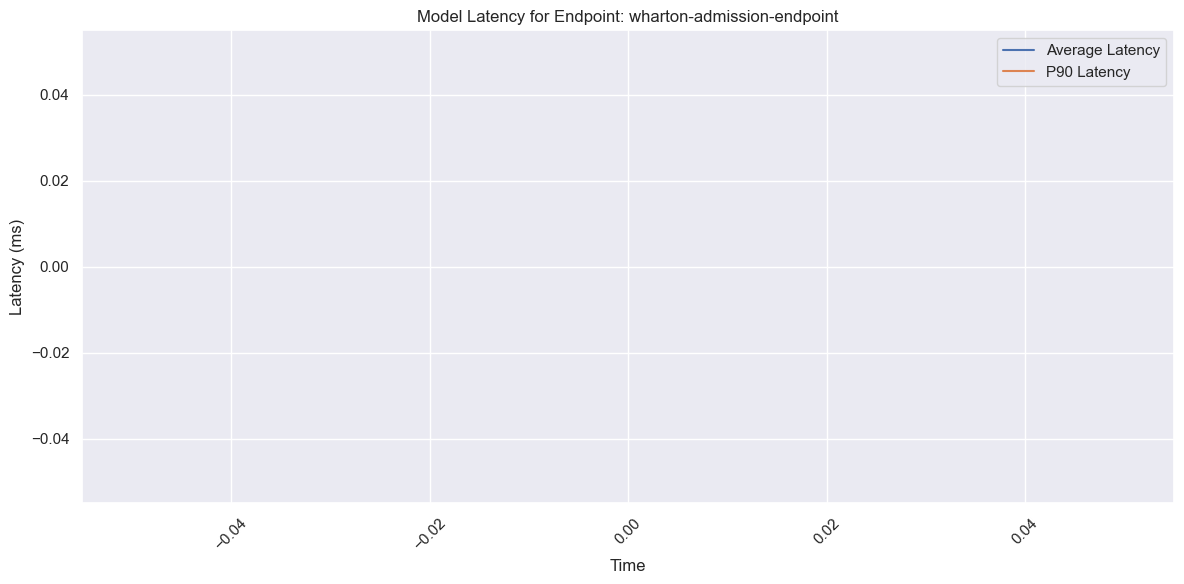


Latency Metrics Summary:
       timestamp  average_latency_ms  p90_latency_ms
count        0.0                 0.0             0.0
mean         NaN                 NaN             NaN
std          NaN                 NaN             NaN
min          NaN                 NaN             NaN
25%          NaN                 NaN             NaN
50%          NaN                 NaN             NaN
75%          NaN                 NaN             NaN
max          NaN                 NaN             NaN


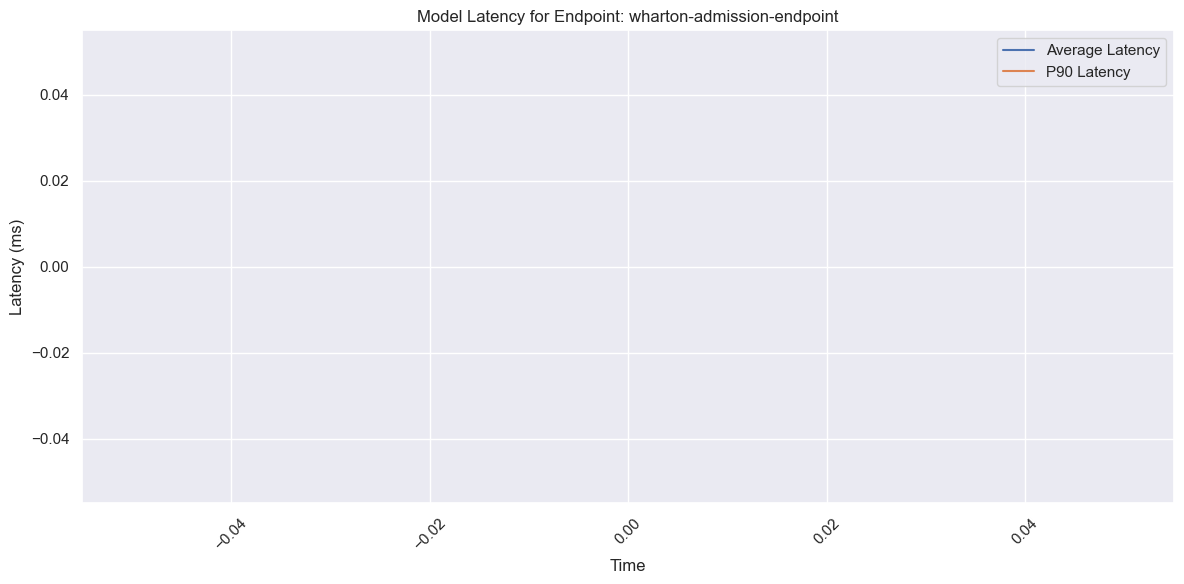

In [170]:
import boto3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError

# Initialize CloudWatch client
cloudwatch = boto3.client('cloudwatch')

def get_endpoint_latency(endpoint_name, start_time=None, end_time=None, period=60):
    """
    Get latency metrics for a SageMaker endpoint from CloudWatch
    
    Args:
        endpoint_name (str): Name of the SageMaker endpoint
        start_time (datetime): Start time for metrics (default: 1 hour ago)
        end_time (datetime): End time for metrics (default: now)
        period (int): Period in seconds (default: 60 seconds /
    """
    # Set default time range if not provided
    if end_time is None:
        end_time = datetime.datetime.utcnow()
    if start_time is None:
        start_time = end_time - datetime.timedelta(hours=1)

    try:
        # Get model latency metrics
        response = cloudwatch.get_metric_data(
            MetricDataQueries=[
                {
                    'Id': 'model_latency',
                    'MetricStat': {
                        'Metric': {
                            'Namespace': 'AWS/SageMaker',
                            'MetricName': 'ModelLatency',
                            'Dimensions': [
                                {
                                    'Name': 'EndpointName',
                                    'Value': endpoint_name
                                }
                            ]
                        },
                        'Period': period,
                        'Stat': 'Average'
                    }
                },
                {
                    'Id': 'model_latency_p90',
                    'MetricStat': {
                        'Metric': {
                            'Namespace': 'AWS/SageMaker',
                            'MetricName': 'ModelLatency',
                            'Dimensions': [
                                {
                                    'Name': 'EndpointName',
                                    'Value': endpoint_name
                                }
                            ]
                        },
                        'Period': period,
                        'Stat': 'p90'
                    }
                }
            ],
            StartTime=start_time,
            EndTime=end_time
        )

        # Create DataFrame from response
        timestamps = response['MetricDataResults'][0]['Timestamps']
        avg_latency = response['MetricDataResults'][0]['Values']
        p90_latency = response['MetricDataResults'][1]['Values']

        df = pd.DataFrame({
            'timestamp': timestamps,
            'average_latency_ms': avg_latency,
            'p90_latency_ms': p90_latency
        })
        
        # Sort by timestamp
        df = df.sort_values('timestamp')
        
        # Plot metrics
        plt.figure(figsize=(12, 6))
        plt.plot(df['timestamp'], df['average_latency_ms'], label='Average Latency')
        plt.plot(df['timestamp'], df['p90_latency_ms'], label='P90 Latency')
        plt.xlabel('Time')
        plt.ylabel('Latency (ms)')
        plt.title(f'Model Latency for Endpoint: {endpoint_name}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return df

    except ClientError as e:
        print(f"Error getting metrics: {e}")
        return None

# Example usage
endpoint_name = ENDPOINT # Replace with your endpoint name

# Get metrics for the last hour
df = get_endpoint_latency(endpoint_name)
print("\nLatency Metrics Summary:")
print(df.describe())

# Get metrics for a specific time range
start_time = datetime.datetime.utcnow() - datetime.timedelta(days=1)
end_time = datetime.datetime.utcnow()
df_custom = get_endpoint_latency(
    endpoint_name,
    start_time=start_time,
    end_time=end_time,
    period=3600  # 1-hour periods
)



In [ ]:
# Set up CloudWatch alarm for high latency
try:
    cloudwatch.put_metric_alarm(
        AlarmName=f'{endpoint_name}-high-latency',
        ComparisonOperator='GreaterThanThreshold',
        EvaluationPeriods=2,
        MetricName='ModelLatency',
        Namespace='AWS/SageMaker',
        Period=300,
        Statistic='Average',
        Threshold=1000,  # 1000 ms = 1 second
        ActionsEnabled=True,
        AlarmDescription='Alert when model latency is too high',
        Dimensions=[
            {
                'Name': 'EndpointName',
                'Value': endpoint_name
            }
        ],
        AlarmActions=[
            'arn:aws:sns:region:account-id:topic-name'  # Replace with your SNS topic ARN
        ]
    )
    print("\nCloudWatch alarm created successfully")
except ClientError as e:
    print(f"Error creating alarm: {e}")